In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import chart_studio.plotly as py # visualization library
from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 
import plotly.graph_objs as go # plotly graphical object
plt.style.use('ggplot') # style of plots. ggplot is one of the most used style
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv("merged_df.csv", parse_dates=["cif_date", "acct_open_date", "Dateloaded"], dayfirst=True)
len(data)

1917

In [3]:
data.head()

,recommended_business_segment,CustomerID,accountno,accountname,accountofficercode,segments,balance_sheet_line,mpr_line,asset_deposits,captionname,...,TransactionSumAmount_RideHailing,TransactionSumAmount_Savings/Investment,TransactionSumAmount_School,TransactionSumAmount_Shopping,TransactionSumAmount_Social,TransactionSumAmount_Transport,TransactionSumAmount_Travel_Hotel,TransactionSumAmount_Wellness,SpendInterests,Dateloaded
0,HNI,20448,26994678,JONATHAN ONYIBO NWORA,505508,ELITE,DOMICILIARY ACCOUNTS,Domiciliary Deposit,Total Deposits,DOMICILIARY ACCOUNTS - FCY,...,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,EatOut,2024-07-28
1,HNI,21076,17506969,OLUWATOYIN AND RASHEED SARUMI,512384,ELITE,DOMICILIARY ACCOUNTS,Domiciliary Deposit,Total Deposits,DOMICILIARY ACCOUNTS - FCY,...,0.0,0.0,5000000.0,62887.50,45000.0,0,99500.0,0.0,"Travel_Hotel, School",2024-07-28
2,HNI,21896,3566760,ADAEZE EUGENIA ONYIA,505508,ELITE,CURRENT ACCOUNTS,Demand Deposit,Total Deposits,CURRENT ACCOUNTS,...,0.0,0.0,0.0,0.00,0.0,0,543500.0,0.0,Travel_Hotel,2024-07-28
3,HNI,26346,93775790,KUNLE TONY KAYODE,502292,ELITE,SAVINGS ACCOUNTS,Savings Deposit,Total Deposits,SAVINGS ACCOUNTS,...,0.0,0.0,0.0,0.00,0.0,0,5400.0,46500.0,Gas,2024-07-28
4,HNI,30585,43956990,KAYODE KEHINDE FAMUYIRO,30058,MASS AFFLUENT,SAVINGS ACCOUNTS,Savings Deposit,Total Deposits,SAVINGS ACCOUNTS,...,0.0,0.0,0.0,5609.93,20000.0,0,0.0,0.0,"Shopping, EatOut, Household, Gas, Social, Ente...",2024-07-28


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 85 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   recommended_business_segment              1917 non-null   object        
 1   CustomerID                                1917 non-null   int64         
 2   accountno                                 1917 non-null   int64         
 3   accountname                               1917 non-null   object        
 4   accountofficercode                        1917 non-null   object        
 5   segments                                  1917 non-null   object        
 6   balance_sheet_line                        1917 non-null   object        
 7   mpr_line                                  1917 non-null   object        
 8   asset_deposits                            1917 non-null   object        
 9   captionname                   

In [5]:
# separate numerical and categorical columns
num_columns = data.select_dtypes(include=['float64', 'int64']).columns
cat_columns = data.select_dtypes(include=['object']).columns

# Impute categorical columns with the mode
for col in cat_columns:
    data[col] = SimpleImputer(strategy="most_frequent").fit_transform(data[[col]])
    
# Impute numerical columns with the median
for col in num_columns:
    data[col] = SimpleImputer(strategy="median").fit_transform(data[[col]])
    
# verify there are no missing values left
missing_values_post_imputation = data.isnull().sum().sum()

missing_values_post_imputation

0

In [6]:
# check for missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 85 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   recommended_business_segment              1917 non-null   object        
 1   CustomerID                                1917 non-null   float64       
 2   accountno                                 1917 non-null   float64       
 3   accountname                               1917 non-null   object        
 4   accountofficercode                        1917 non-null   object        
 5   segments                                  1917 non-null   object        
 6   balance_sheet_line                        1917 non-null   object        
 7   mpr_line                                  1917 non-null   object        
 8   asset_deposits                            1917 non-null   object        
 9   captionname                   

There are no missing values in the dataset.

### Exploratory Data Analysis

### Behavioral Analysis

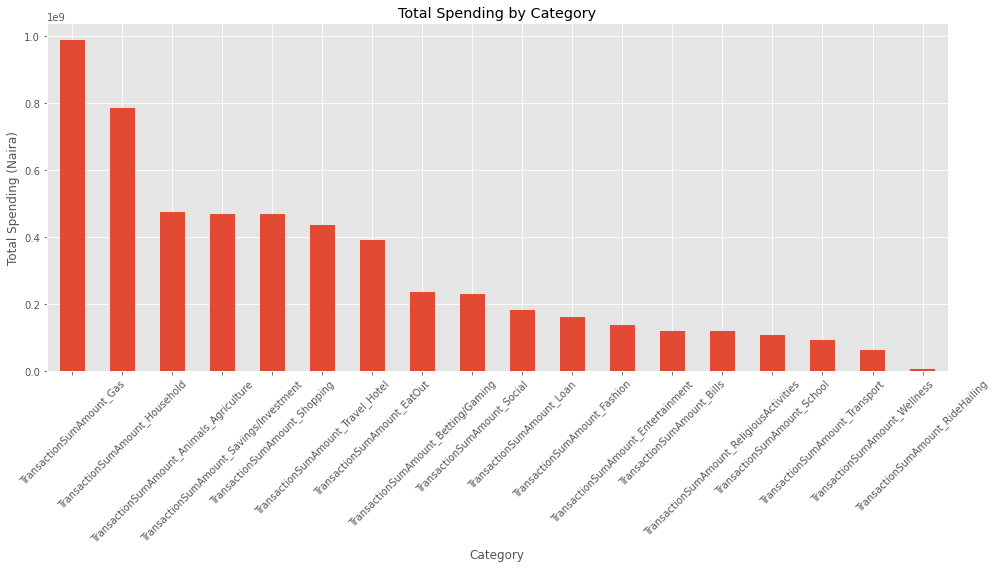

In [7]:
# 1. Spending Habits Analysis
# Sum up spending across all categories
spending_columns = data.filter(like='TransactionSumAmount_').columns
category_spending = data[spending_columns].sum().sort_values(ascending=False)

# Plot highest spending categories
plt.figure(figsize=(14, 8))
category_spending.plot(kind='bar', title='Total Spending by Category', ylabel='Total Spending (Naira)', xlabel='Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

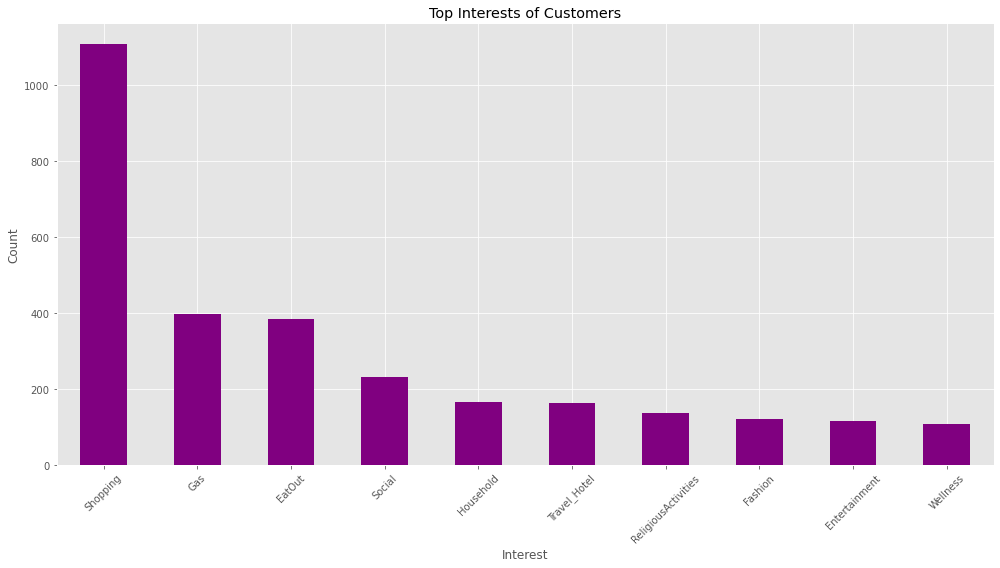

In [8]:
# 2. Top Interests Analysis
# Group customers by shared interests and evaluate spending patterns
spend_interests = data['SpendInterests'].dropna().str.split(', ').explode()
spend_interests_counts = spend_interests.value_counts()

# Plot top interests
plt.figure(figsize=(14, 8))
spend_interests_counts.head(10).plot(kind='bar', title='Top Interests of Customers', ylabel='Count', xlabel='Interest', color='purple')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

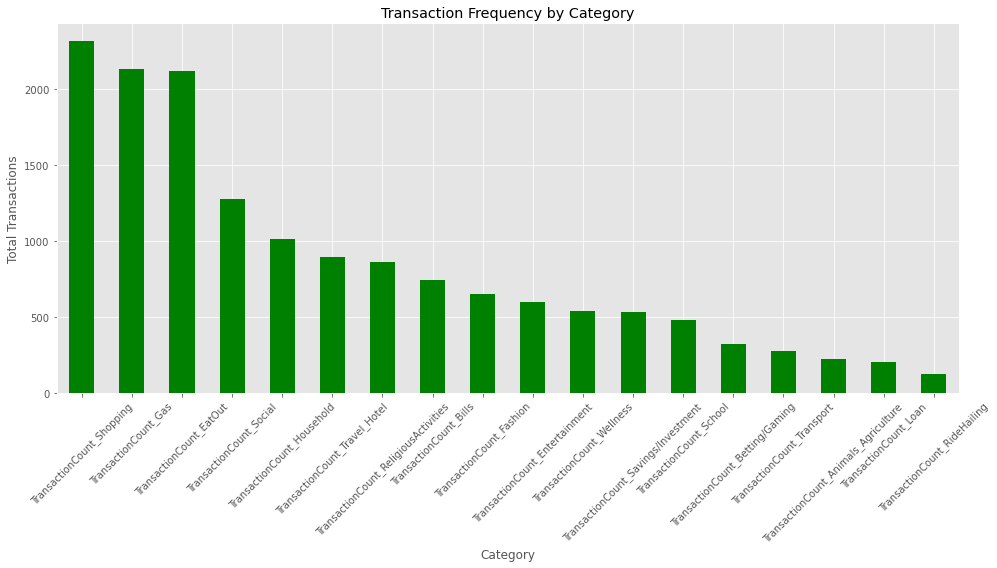

In [9]:
# 3. Frequency Analysis
# Calculate average transaction value for each category
transaction_count_columns = data.filter(like='TransactionCount_').columns

# Sum transaction frequency by categories
transaction_frequency = data[transaction_count_columns].sum().sort_values(ascending=False)

# Plot transaction frequencies by category
plt.figure(figsize=(14, 8))
transaction_frequency.plot(kind='bar', title='Transaction Frequency by Category', ylabel='Total Transactions', xlabel='Category', color='green')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Spending Habits:

Total spending across categories highlights high-spend areas like Gas, Household, Shopping, Travel_Hotel, EatOut, savings/investments etc.

Top Interests:

Grouped customers by shared interests and visualized the most common ones, such as Shopping and Gas, EatOut aligning with their spending patterns.

Frequency Analysis:

Transaction frequency for each category, identifying habits such as frequent dining, traveling, or other recurring activities.

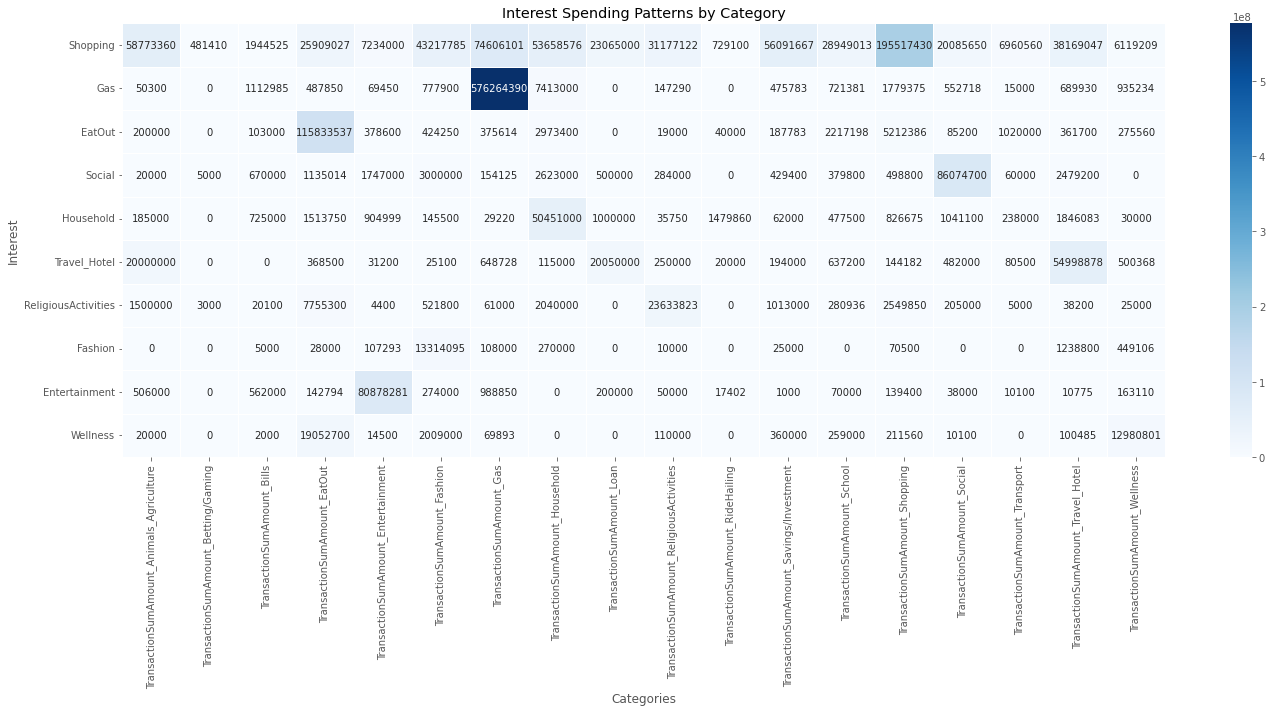

In [10]:
# 1. Interests and Spending Alignment: Group by top interests and align spending patterns
spending_by_interest = spend_interests.value_counts().head(10).index
interest_spending = data[data['SpendInterests'].notna()].groupby('SpendInterests')[spending_columns].sum().loc[spending_by_interest]

# 2. Frequency Segmentation: Categorize customers into segments based on transaction frequency
frequency_segments = pd.cut(transaction_frequency, bins=[0, 500, 2000, 5000], labels=['Low Frequency', 'Medium Frequency', 'High Frequency'])

# Visualizing interest spending heatmap across categories
plt.figure(figsize=(20, 10))
sns.heatmap(interest_spending, cmap='Blues', annot=True, fmt='.0f', linewidths=.5)
plt.title('Interest Spending Patterns by Category')
plt.xlabel('Categories')
plt.ylabel('Interest')
plt.tight_layout()
plt.show()

In [11]:
interest_spending

,TransactionSumAmount_Animals_Agriculture,TransactionSumAmount_Betting/Gaming,TransactionSumAmount_Bills,TransactionSumAmount_EatOut,TransactionSumAmount_Entertainment,TransactionSumAmount_Fashion,TransactionSumAmount_Gas,TransactionSumAmount_Household,TransactionSumAmount_Loan,TransactionSumAmount_ReligiousActivities,TransactionSumAmount_RideHailing,TransactionSumAmount_Savings/Investment,TransactionSumAmount_School,TransactionSumAmount_Shopping,TransactionSumAmount_Social,TransactionSumAmount_Transport,TransactionSumAmount_Travel_Hotel,TransactionSumAmount_Wellness
Shopping,58773360.0,481410.0,1944525.0,2.590903e+07,7234000.0,43217785.0,7.460610e+07,53658575.63,23065000.0,31177122.0,729100.00,56091667.32,28949013.24,1.955174e+08,20085650.0,6960560.0,38169046.61,6119209.07
Gas,50300.0,0.0,1112985.0,4.878500e+05,69450.0,777900.0,5.762644e+08,7413000.00,0.0,147290.0,0.00,475783.03,721381.18,1.779375e+06,552718.0,15000.0,689930.00,935234.40
EatOut,200000.0,0.0,103000.0,1.158335e+08,378600.0,424250.0,3.756138e+05,2973400.00,0.0,19000.0,40000.00,187783.00,2217197.50,5.212386e+06,85200.0,1020000.0,361700.00,275560.00
Social,20000.0,5000.0,670000.0,1.135014e+06,1747000.0,3000000.0,1.541250e+05,2623000.00,500000.0,284000.0,0.00,429400.00,379800.00,4.988000e+05,86074700.0,60000.0,2479200.00,0.00
Household,185000.0,0.0,725000.0,1.513750e+06,904999.0,145500.0,2.922000e+04,50451000.00,1000000.0,35750.0,1479859.84,62000.00,477500.00,8.266750e+05,1041100.0,238000.0,1846083.00,30000.00
Travel_Hotel,20000000.0,0.0,0.0,3.685000e+05,31200.0,25100.0,6.487280e+05,115000.00,20050000.0,250000.0,20000.00,194000.00,637200.00,1.441825e+05,482000.0,80500.0,54998878.00,500368.33
ReligiousActivities,1500000.0,3000.0,20100.0,7.755300e+06,4400.0,521800.0,6.100000e+04,2040000.00,0.0,23633823.0,0.00,1013000.00,280936.50,2.549850e+06,205000.0,5000.0,38200.00,25000.00
Fashion,0.0,0.0,5000.0,2.800000e+04,107293.0,13314095.0,1.080000e+05,270000.00,0.0,10000.0,0.00,25000.00,0.00,7.050000e+04,0.0,0.0,1238800.00,449106.00
Entertainment,506000.0,0.0,562000.0,1.427940e+05,80878281.0,274000.0,9.888500e+05,0.00,200000.0,50000.0,17401.92,1000.00,70000.00,1.394000e+05,38000.0,10100.0,10775.08,163110.00
Wellness,20000.0,0.0,2000.0,1.905270e+07,14500.0,2009000.0,6.989300e+04,0.00,0.0,110000.0,0.00,360000.00,259000.00,2.115600e+05,10100.0,0.0,100485.00,12980800.99


In [12]:
frequency_segments.value_counts()

Medium Frequency    9
Low Frequency       6
High Frequency      3
dtype: int64

Interests and Spending Alignment:

Spending patterns grouped by top interests, such as Shopping, Gas, and Social Activities, showing how interests align with category spending.

Frequency Segmentation:

Customers segmented into Low Frequency, Medium Frequency, and High Frequency groups based on transaction counts.

#### Segment Customers by Spending

In [13]:
# Summing up all transaction categories to create a TotalSpending column for each customer
data['TotalSpending'] = data.filter(like='TransactionSumAmount_').sum(axis=1)

# Define spending thresholds for segmentation
spending_bins = [0, 1000000, 5000000, 10000000, 25000000, data['TotalSpending'].max()]
spending_labels = ['Low Spender', 'Moderate Spender', 'High Spender', 'Very High Spender', 'Luxury Spender']

# Create a new column for spending segments
data['SpendingSegment'] = pd.cut(data['TotalSpending'], bins=spending_bins, labels=spending_labels)

# Count customers in each segment
spending_segment_counts = data['SpendingSegment'].value_counts()

# Display spending segment counts
print("\nSpending Segment Counts:")
print(spending_segment_counts)

# Export to CSV for further review
# data[['CustomerID', 'TotalSpending', 'SpendingSegment']].to_csv("Customer_Spending_Segments.csv", index=False)
# spending_segment_counts.to_csv("Spending_Segment_Counts.csv", index=True)



Spending Segment Counts:
Low Spender          1405
Moderate Spender      341
High Spender           70
Very High Spender      58
Luxury Spender         43
Name: SpendingSegment, dtype: int64


In [14]:
# Display customer spending segments
print("Customer Spending Segments:")
data[['CustomerID', 'TotalSpending', 'SpendingSegment']]

Customer Spending Segments:


,CustomerID,TotalSpending,SpendingSegment
0,20448.0,108000.00,Low Spender
1,21076.0,5682387.50,High Spender
2,21896.0,543500.00,Low Spender
3,26346.0,116100.00,Low Spender
4,30585.0,2380309.93,Moderate Spender
...,...,...,...
1912,16628616.0,20929000.00,Very High Spender
1913,16633468.0,268170.00,Low Spender
1914,16637897.0,1800000.00,Moderate Spender
1915,16662159.0,112300.00,Low Spender


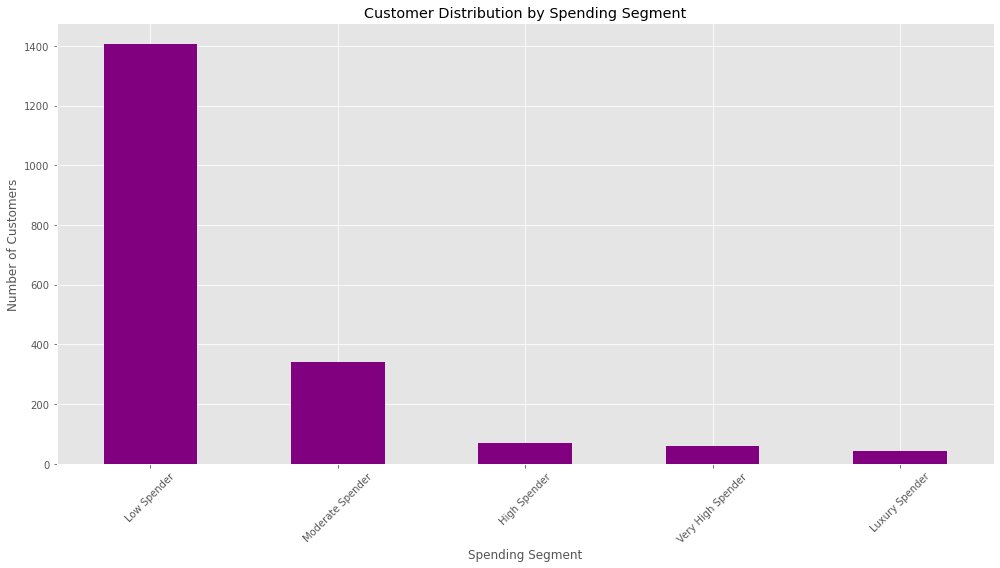

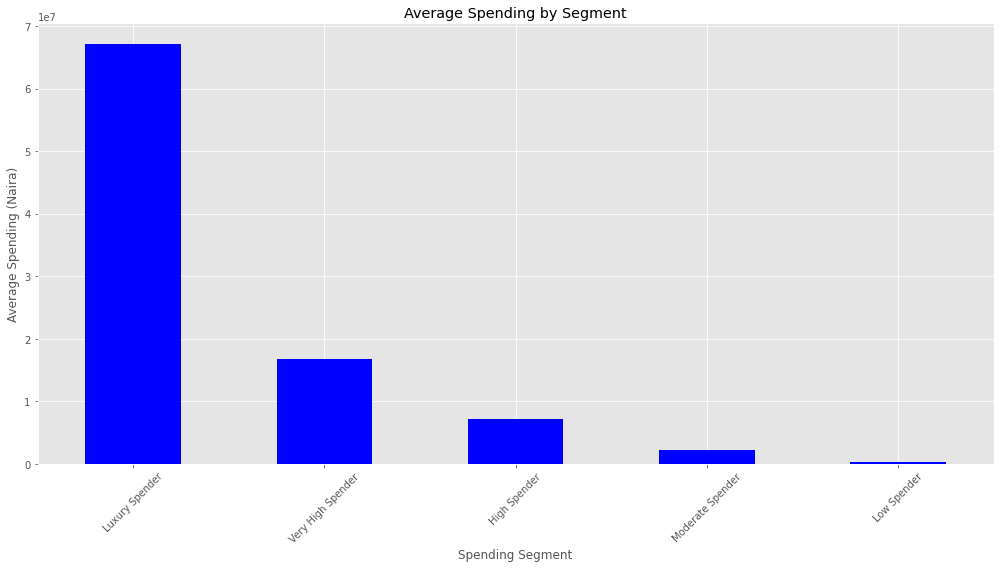

Segmented Spending Trends:


,Customer Count,Average Spending
Low Spender,1405,2.380842e+05
Moderate Spender,341,2.246623e+06
High Spender,70,7.128220e+06
Very High Spender,58,1.676132e+07
Luxury Spender,43,6.706627e+07


In [15]:
# Count customers in each spending segment
spending_segment_counts = data['SpendingSegment'].value_counts()

# Visualize spending segments with a bar chart
plt.figure(figsize=(14, 8))
spending_segment_counts.plot(
    kind='bar', color='purple', title='Customer Distribution by Spending Segment', xlabel='Spending Segment', ylabel='Number of Customers'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze spending trends by segment
spending_trends = data.groupby('SpendingSegment')['TotalSpending'].mean().sort_values(ascending=False)

# Visualize average spending by segment
plt.figure(figsize=(14, 8))
spending_trends.plot(
    kind='bar', color='blue', title='Average Spending by Segment', xlabel='Spending Segment', ylabel='Average Spending (Naira)'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display spending trends for review
import pandas as pd
trends_summary = pd.DataFrame({
    'Customer Count': spending_segment_counts,
    'Average Spending': spending_trends
})

# Display segmented spending trends in the console
print("Segmented Spending Trends:")
trends_summary

# Save trends summary to a CSV file for further analysis
# trends_summary.to_csv("Segmented_Spending_Trends.csv", index=True)

# print("\nSegmented spending trends have been saved as 'Segmented_Spending_Trends.csv'.")

Customers have been segmented into spending categories ranging from "Low Spender" to "Luxury Spender" based on their total transaction amounts.

#### Analysis of High Spenders Pattern

In [16]:
# Filter data for High Spenders and above
high_spenders = data[data['SpendingSegment'].isin(['High Spender', 'Very High Spender', 'Luxury Spender'])]

# Analyzing patterns within High Spenders
# Top categories for spending
top_categories = high_spenders.filter(like='TransactionSumAmount_').sum().sort_values(ascending=False)

# Regional distribution of High Spenders
regional_distribution = high_spenders['regionname'].value_counts()

# Average spending in top categories for High Spenders
average_spending_top_categories = high_spenders.filter(like='TransactionSumAmount_').mean().sort_values(ascending=False)

# # Save results to CSV files for further analysis
# high_spenders.to_csv("High_Spenders_Data.csv", index=False)
# top_categories.to_csv("Top_Categories.csv", index=True)
# regional_distribution.to_csv("Regional_Distribution.csv", index=True)
# average_spending_top_categories.to_csv("Average_Spending_Top_Categories.csv", index=True)
# print("\nData has been saved as CSV files for further review.")

In [17]:
# Display high spenders data
print("High Spenders Data:")
high_spenders.head()

High Spenders Data:


,recommended_business_segment,CustomerID,accountno,accountname,accountofficercode,segments,balance_sheet_line,mpr_line,asset_deposits,captionname,...,TransactionSumAmount_School,TransactionSumAmount_Shopping,TransactionSumAmount_Social,TransactionSumAmount_Transport,TransactionSumAmount_Travel_Hotel,TransactionSumAmount_Wellness,SpendInterests,Dateloaded,TotalSpending,SpendingSegment
1,HNI,21076.0,17506969.0,OLUWATOYIN AND RASHEED SARUMI,512384,ELITE,DOMICILIARY ACCOUNTS,Domiciliary Deposit,Total Deposits,DOMICILIARY ACCOUNTS - FCY,...,5000000.0,62887.5,45000.0,0.0,99500.0,0.0,"Travel_Hotel, School",2024-07-28,5682387.5,High Spender
9,HNI,47204.0,84826128.0,SALISU UMAR,514847,ELITE,DOMICILIARY ACCOUNTS,Domiciliary Deposit,Total Deposits,DOMICILIARY ACCOUNTS - FCY,...,350000.0,120000.0,320000.0,0.0,50000.0,0.0,"Shopping, Bills, Household, School, Gas, Socia...",2024-07-28,5556600.0,High Spender
33,HNI,86414.0,18183653.0,OLIVER OBI EKWO,515835,ELITE,CURRENT ACCOUNTS,Demand Deposit,Total Deposits,CURRENT ACCOUNTS,...,0.0,0.0,0.0,977550.0,0.0,0.0,"EatOut, Transport, Household",2024-07-28,6457550.0,High Spender
64,HNI,164763.0,79645433.0,OGO UCHE UPRIGHT,512584,ELITE,SAVINGS ACCOUNTS,Savings Deposit,Total Deposits,SAVINGS ACCOUNTS,...,279000.0,24000.0,10000.0,0.0,0.0,0.0,"Shopping, Household, School",2024-07-28,14460700.0,Very High Spender
80,HNI,200195.0,7913496.0,TIMOTHY KOLADE OLASUNKANMI,502661,ELITE,SAVINGS ACCOUNTS,Savings Deposit,Total Deposits,SAVINGS ACCOUNTS,...,0.0,0.0,0.0,0.0,0.0,0.0,Savings/Investment,2024-07-28,70000000.0,Luxury Spender


In [18]:
# Display additional insights
print("\nTop Categories:")
top_categories


Top Categories:


TransactionSumAmount_Gas                    9.123069e+08
TransactionSumAmount_Household              6.391236e+08
TransactionSumAmount_Animals_Agriculture    4.360231e+08
TransactionSumAmount_Savings/Investment     4.098683e+08
TransactionSumAmount_Travel_Hotel           3.456542e+08
TransactionSumAmount_Shopping               3.387167e+08
TransactionSumAmount_EatOut                 2.947098e+08
TransactionSumAmount_Betting/Gaming         2.220025e+08
TransactionSumAmount_Loan                   1.244380e+08
TransactionSumAmount_Social                 1.166463e+08
TransactionSumAmount_Fashion                1.156266e+08
TransactionSumAmount_Bills                  9.512331e+07
TransactionSumAmount_Entertainment          9.490405e+07
TransactionSumAmount_Transport              7.057545e+07
TransactionSumAmount_ReligiousActivities    5.808345e+07
TransactionSumAmount_School                 5.292412e+07
TransactionSumAmount_Wellness               2.774055e+07
TransactionSumAmount_RideHailin

In [19]:
print("\nRegional Distribution:")
print(regional_distribution)


Regional Distribution:
RCB - SOUTH-SOUTH & SOUTH EAST    39
RCB - LAGOS ISLAND                34
RCB - LAGOS MAINLAND              27
RCB - NORTH WEST                  25
RCB - ABUJA/NORTH EAST/CENTRAL    23
RCB - SOUTH WEST                  22
VIRTUAL ACCOUNT                    1
Name: regionname, dtype: int64


In [20]:
print("\nAverage Spending by Top Categories:")
average_spending_top_categories


Average Spending by Top Categories:


TransactionSumAmount_Gas                    5.335128e+06
TransactionSumAmount_Household              3.737565e+06
TransactionSumAmount_Animals_Agriculture    2.549843e+06
TransactionSumAmount_Savings/Investment     2.396891e+06
TransactionSumAmount_Travel_Hotel           2.021369e+06
TransactionSumAmount_Shopping               1.980799e+06
TransactionSumAmount_EatOut                 1.723449e+06
TransactionSumAmount_Betting/Gaming         1.298260e+06
TransactionSumAmount_Loan                   7.277076e+05
TransactionSumAmount_Social                 6.821419e+05
TransactionSumAmount_Fashion                6.761787e+05
TransactionSumAmount_Bills                  5.562767e+05
TransactionSumAmount_Entertainment          5.549944e+05
TransactionSumAmount_Transport              4.127219e+05
TransactionSumAmount_ReligiousActivities    3.396693e+05
TransactionSumAmount_School                 3.094978e+05
TransactionSumAmount_Wellness               1.622254e+05
TransactionSumAmount_RideHailin

`High Spenders' Patterns`
- Top Spending Categories:

    - Gas: The highest spending category with a total amount of approximately 912 million.
    - Household and Agriculture: Significant spending observed in these categories, with over 639 million and 436 million, respectively.
    - Other major categories include Savings/Investment, Shopping, Travel/Hotel, and EatOut.

- Regional Distribution:

    - The highest concentration of high spenders is in:
    - South-South & South East (39 customers)
    - Lagos Island (34 customers)
    - Lagos Mainland (27 customers)
    - Notable presence in North West (25) and Abuja/North East/Central (23).

- Average Spending in Top Categories:
    - Gas: 5.3 million naira per high spender on average.

    - Household: 3.7 million per high spender.

    - Categories like Savings/Investment, Shopping, and Travel/Hotel have averages of about 2.1 million.


#### Analysis of luxury spenders by top categories

In [21]:
# Filter data for Luxury Spenders
luxury_spenders = data[data['SpendingSegment'] == 'Luxury Spender']

# Analyze top categories for spending among Luxury Spenders
luxury_top_categories = luxury_spenders.filter(like='TransactionSumAmount_').sum().sort_values(ascending=False)

# Average spending in top categories for Luxury Spenders
luxury_avg_spending_top_categories = luxury_spenders.filter(like='TransactionSumAmount_').mean().sort_values(ascending=False)

# Regional distribution of Luxury Spenders
luxury_regional_distribution = luxury_spenders['regionname'].value_counts()

# Save results to CSV files for further review
# luxury_spenders.to_csv("Luxury_Spenders_Data.csv", index=False)
# luxury_top_categories.to_csv("Luxury_Top_Categories.csv", index=True)
# luxury_avg_spending_top_categories.to_csv("Luxury_Avg_Spending_Top_Categories.csv", index=True)
# luxury_regional_distribution.to_csv("Luxury_Regional_Distribution.csv", index=True)

In [22]:
# Display luxury spenders data
print("Luxury Spenders Data:")
luxury_spenders.head()

Luxury Spenders Data:


,recommended_business_segment,CustomerID,accountno,accountname,accountofficercode,segments,balance_sheet_line,mpr_line,asset_deposits,captionname,...,TransactionSumAmount_School,TransactionSumAmount_Shopping,TransactionSumAmount_Social,TransactionSumAmount_Transport,TransactionSumAmount_Travel_Hotel,TransactionSumAmount_Wellness,SpendInterests,Dateloaded,TotalSpending,SpendingSegment
80,HNI,200195.0,7913496.0,TIMOTHY KOLADE OLASUNKANMI,502661,ELITE,SAVINGS ACCOUNTS,Savings Deposit,Total Deposits,SAVINGS ACCOUNTS,...,0.0,0.0,0.0,0.0,0.0,0.0,Savings/Investment,2024-07-28,70000000.0,Luxury Spender
88,HNI,212709.0,9943570.0,YETUNDE IDOWU ALABI,514785,ELITE,CURRENT ACCOUNTS,Demand Deposit,Total Deposits,CURRENT ACCOUNTS,...,0.0,80000000.0,0.0,0.0,0.0,0.0,Shopping,2024-07-28,80156134.0,Luxury Spender
209,HNI,426467.0,17978191.0,ALIYU SULEIMAN UMAR,509820,ELITE,SAVINGS ACCOUNTS,Savings Deposit,Total Deposits,SAVINGS ACCOUNTS,...,33000.0,0.0,0.0,0.0,0.0,8280000.0,Wellness,2024-07-28,29013000.0,Luxury Spender
338,HNI,829980.0,24492338.0,OLUMIDE OPEYEMI OGUNBANJO,517286,MASS MARKET,SAVINGS ACCOUNTS,Savings Deposit,Total Deposits,SAVINGS ACCOUNTS,...,0.0,1800000.0,0.0,0.0,0.0,0.0,"Shopping, Gas",2024-07-28,51800000.0,Luxury Spender
439,HNI,1308285.0,31458967.0,AGBOOLA OLATUNJI OLOWOLAIYEMO,500379,ELITE,SAVINGS ACCOUNTS,Savings Deposit,Total Deposits,SAVINGS ACCOUNTS,...,0.0,0.0,0.0,0.0,0.0,0.0,Savings/Investment,2024-07-28,85600000.0,Luxury Spender


In [23]:
# Display additional insights
print("\nLuxury Top Categories:")
luxury_top_categories


Luxury Top Categories:


TransactionSumAmount_Gas                    768701100.0
TransactionSumAmount_Household              399777700.0
TransactionSumAmount_Animals_Agriculture    323567740.0
TransactionSumAmount_Savings/Investment     241043634.0
TransactionSumAmount_Travel_Hotel           237776580.0
TransactionSumAmount_Betting/Gaming         215736000.0
TransactionSumAmount_Shopping               196245751.0
TransactionSumAmount_EatOut                 195376350.0
TransactionSumAmount_Entertainment           68807900.0
TransactionSumAmount_Transport               58067000.0
TransactionSumAmount_Loan                    50676000.0
TransactionSumAmount_Bills                   42399420.0
TransactionSumAmount_Fashion                 33204491.5
TransactionSumAmount_Social                  29390250.0
TransactionSumAmount_Wellness                 9285600.0
TransactionSumAmount_School                   8526440.0
TransactionSumAmount_ReligiousActivities      5267515.0
TransactionSumAmount_RideHailing                

In [24]:
print("\nLuxury Average Spending by Top Categories:")
luxury_avg_spending_top_categories


Luxury Average Spending by Top Categories:


TransactionSumAmount_Gas                    1.787677e+07
TransactionSumAmount_Household              9.297156e+06
TransactionSumAmount_Animals_Agriculture    7.524831e+06
TransactionSumAmount_Savings/Investment     5.605666e+06
TransactionSumAmount_Travel_Hotel           5.529688e+06
TransactionSumAmount_Betting/Gaming         5.017116e+06
TransactionSumAmount_Shopping               4.563855e+06
TransactionSumAmount_EatOut                 4.543636e+06
TransactionSumAmount_Entertainment          1.600184e+06
TransactionSumAmount_Transport              1.350395e+06
TransactionSumAmount_Loan                   1.178512e+06
TransactionSumAmount_Bills                  9.860330e+05
TransactionSumAmount_Fashion                7.721975e+05
TransactionSumAmount_Social                 6.834942e+05
TransactionSumAmount_Wellness               2.159442e+05
TransactionSumAmount_School                 1.982893e+05
TransactionSumAmount_ReligiousActivities    1.225003e+05
TransactionSumAmount_RideHailin

In [25]:
print("\nLuxury Regional Distribution:")
luxury_regional_distribution


Luxury Regional Distribution:


RCB - ABUJA/NORTH EAST/CENTRAL    11
RCB - NORTH WEST                   8
RCB - LAGOS ISLAND                 7
RCB - SOUTH WEST                   6
RCB - LAGOS MAINLAND               6
RCB - SOUTH-SOUTH & SOUTH EAST     5
Name: regionname, dtype: int64

`Luxury Spenders' Analysis by Top Categories`

- Top Spending Categories:

    - Gas: Highest total spending (~768 million).
    - Household: Significant spending (~400 million).
    - Animals/Agriculture, Savings/Investment, and Shopping each account for over 200 million.
    - Travel/Hotel and Betting/Gaming are also key categories.


- Average Spending Per Category:

    - Gas: ~17.8 million per spender.
    - Household: ~9.2 million per spender.
    - Animals/Agriculture and Savings/Investment, Travel/Hotel average over 5.5 million each.


- Other notable averages:
    - Betting/Gaming: over 5 million naira
    - Shopping: over 4,5 million naira
    - EatOut: over 4.5 million naira

#### Analyze savings/investments patterns by segments

<Figure size 720x432 with 0 Axes>

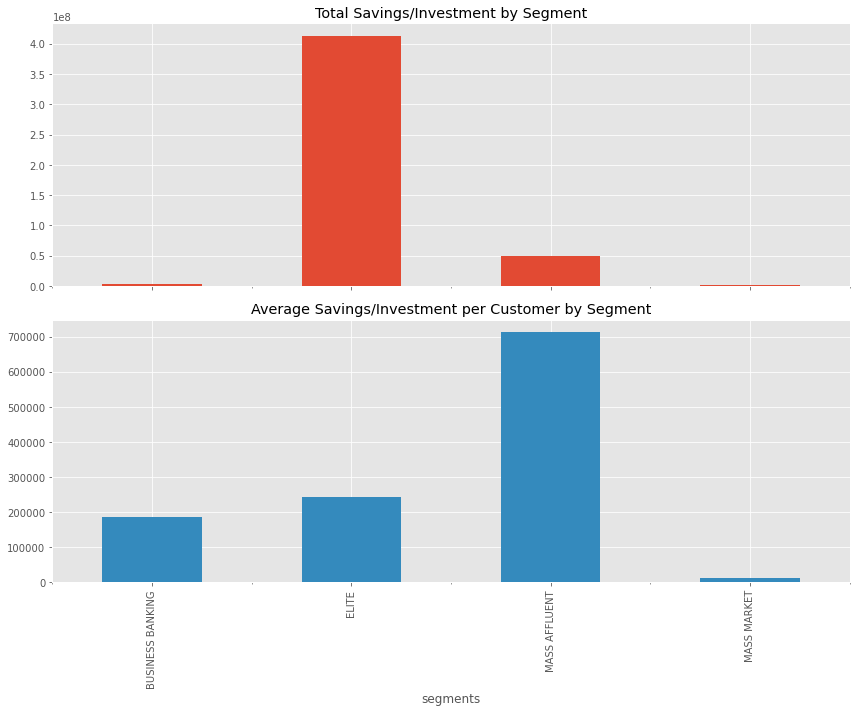

Savings and Investment Patterns by Segment:


,Total_Savings_Investment,Average_Savings_Investment,Customer_Count,Avg_Savings_Investment_per_Customer
segments,,,,
BUSINESS BANKING,3.729400e+06,186470.000000,20,186470.000000
ELITE,4.128833e+08,242302.423374,1704,242302.423374
MASS AFFLUENT,4.986569e+07,712367.053571,70,712367.053571
MASS MARKET,1.589963e+06,12926.528455,123,12926.528455


In [26]:
# Analyzing savings/investment patterns by segments
savings_investment_by_segment = data.groupby('segments')['TransactionSumAmount_Savings/Investment'].agg(
    Total_Savings_Investment='sum',
    Average_Savings_Investment='mean',
    Customer_Count='count'
)

# Calculate the average savings/investment per customer
savings_investment_by_segment['Avg_Savings_Investment_per_Customer'] = (
    savings_investment_by_segment['Total_Savings_Investment'] / savings_investment_by_segment['Customer_Count']
)

# Visualize savings/investment patterns
plt.figure(figsize=(10, 6))
savings_investment_by_segment[['Total_Savings_Investment', 'Avg_Savings_Investment_per_Customer']].plot(
    kind='bar', subplots=True, layout=(2, 1), figsize=(12, 10), legend=False,
    title=['Total Savings/Investment by Segment', 'Average Savings/Investment per Customer by Segment']
)
plt.tight_layout()
plt.show()

# Display savings and investment patterns by segment
print("Savings and Investment Patterns by Segment:")
savings_investment_by_segment

# Save the data to a CSV file for further analysis
# savings_investment_by_segment.to_csv("Savings_Investment_Patterns_By_Segment.csv", index=False)

The analysis of savings and investment patterns across segments reveals the following:

`Total Savings/Investment:`

    - Elite segment dominates with a total of ~₦412.8 million.
    - Mass Affluent follows with ~₦49.9 million, while Business Banking and Mass Market contribute smaller totals.

`Average Savings/Investment:`

    - Mass Affluent has the highest average savings/investment per customer (~₦712,000), indicating significant individual contributions.
    - Elite shows moderate average savings (~₦242,000), reflecting its broader customer base.

`Customer Count:`

    - The Elite segment has the largest customer base (1,704 customers), driving the highest total savings.

#### Demographic trends among luxury spenders

In [27]:
# Group by demographic-related columns and count occurrences
demographic_trends = luxury_spenders.groupby(['recommended_business_segment', 'segments', 'regionname']).size().reset_index(name='Count')

# Summarize trends
business_segment_distribution = luxury_spenders['recommended_business_segment'].value_counts()
customer_segment_distribution = luxury_spenders['segments'].value_counts()
regional_trends = luxury_spenders['regionname'].value_counts()

In [28]:
# Save results to CSV files for further analysis
# demographic_trends.to_csv("Luxury_Demographic_Trends.csv", index=False)
# business_segment_distribution.to_csv("Business_Segment_Distribution.csv", index=True)
# customer_segment_distribution.to_csv("Customer_Segment_Distribution.csv", index=True)
# regional_trends.to_csv("Regional_Trends.csv", index=True)

# Display demographic trends for luxury spenders
print("Luxury Spenders' Demographic Trends:")
demographic_trends.head()

Luxury Spenders' Demographic Trends:


,recommended_business_segment,segments,regionname,Count
0,HNI,ELITE,RCB - ABUJA/NORTH EAST/CENTRAL,9
1,HNI,ELITE,RCB - LAGOS ISLAND,7
2,HNI,ELITE,RCB - LAGOS MAINLAND,6
3,HNI,ELITE,RCB - NORTH WEST,8
4,HNI,ELITE,RCB - SOUTH WEST,4


In [29]:
# Display additional insights
print("\nBusiness Segment Distribution:")
business_segment_distribution


Business Segment Distribution:


HNI    43
Name: recommended_business_segment, dtype: int64

In [30]:
print("\nCustomer Segment Distribution:")
customer_segment_distribution


Customer Segment Distribution:


ELITE            38
MASS MARKET       3
MASS AFFLUENT     2
Name: segments, dtype: int64

In [31]:
print("\nRegional Trends:")
regional_trends


Regional Trends:


RCB - ABUJA/NORTH EAST/CENTRAL    11
RCB - NORTH WEST                   8
RCB - LAGOS ISLAND                 7
RCB - SOUTH WEST                   6
RCB - LAGOS MAINLAND               6
RCB - SOUTH-SOUTH & SOUTH EAST     5
Name: regionname, dtype: int64

#### Investigate transaction frequency by category

<Figure size 1008x576 with 0 Axes>

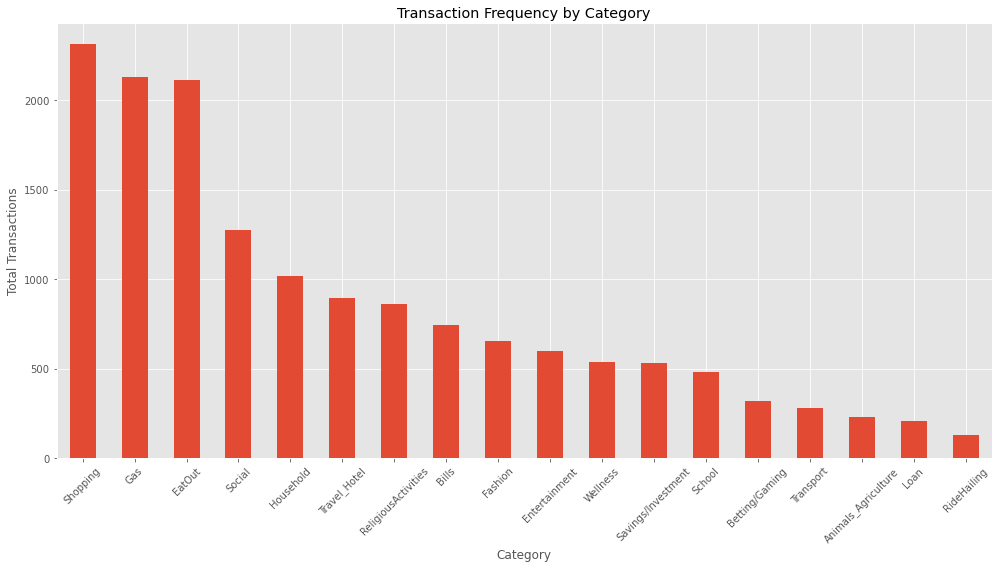

Transaction Frequency by Category:


,Category,Total Transactions
0,Shopping,2313.0
1,Gas,2131.0
2,EatOut,2114.0
3,Social,1276.0
4,Household,1015.0
5,Travel_Hotel,893.0
6,ReligiousActivities,862.0
7,Bills,742.0
8,Fashion,655.0
9,Entertainment,600.0


In [32]:
# Aggregating transaction frequency across all categories
transaction_frequency = data.filter(like='TransactionCount_').sum().sort_values(ascending=False)

# Converting to DataFrame for better visualization
transaction_frequency_df = transaction_frequency.reset_index()
transaction_frequency_df.columns = ['Category', 'Total Transactions']

# Cleaning category names for readability
transaction_frequency_df['Category'] = transaction_frequency_df['Category'].str.replace('TransactionCount_', '')

# Visualizing transaction frequency
plt.figure(figsize=(14, 8))
transaction_frequency_df.plot(
    x='Category', y='Total Transactions', kind='bar', legend=False, title='Transaction Frequency by Category', figsize=(14, 8)
)
plt.ylabel('Total Transactions')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display transaction frequency by category
print("Transaction Frequency by Category:")
transaction_frequency_df

# Save the data to a CSV file for further analysis
# transaction_frequency_df.to_csv("Transaction_Frequency_By_Category.csv", index=False)

The investigation into transaction frequency by category reveals:

`Top Categories by Transaction Count:`

    - Shopping: Most frequent category with 2,313 transactions.
    - Gas and EatOut: Both have over 2,100 transactions, indicating high regular engagement.
    - Social Activities and Household follow, with 1,276 and 1,015 transactions, respectively.

`Insights:`

    - Categories like Shopping, Gas, and EatOut indicate recurring daily or lifestyle-related spending habits.
    - Household and Social activities show moderate but essential engagement.

### Geographic Analysis

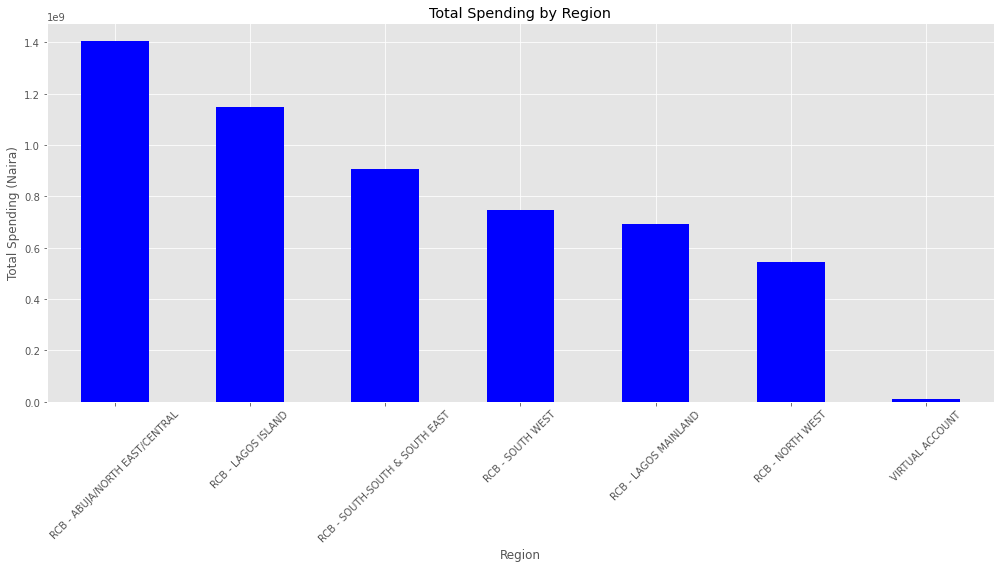

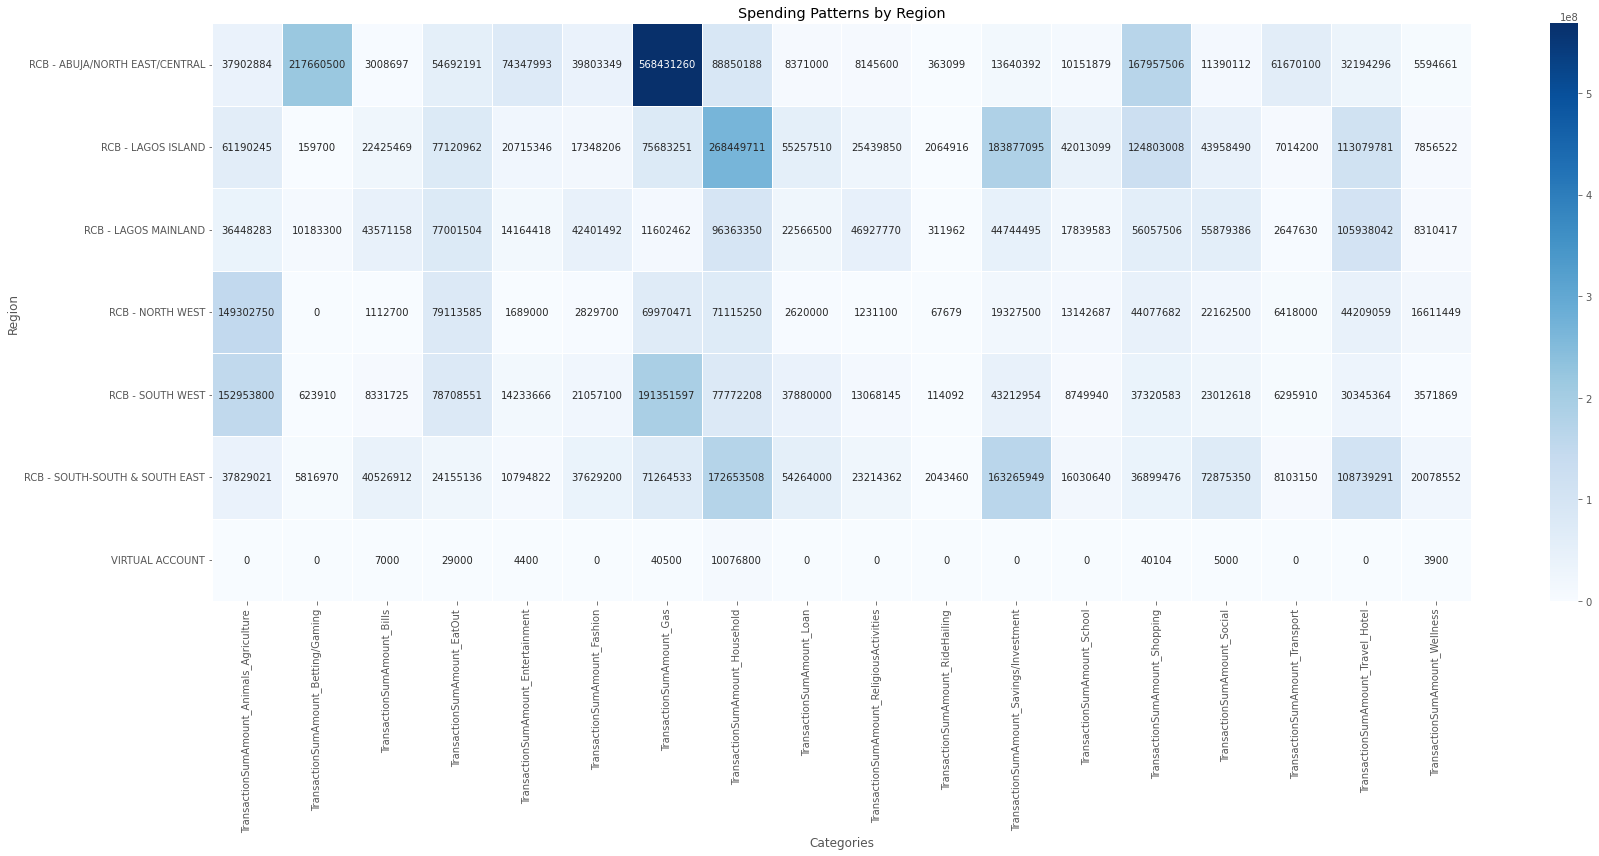

,TransactionSumAmount_Animals_Agriculture,TransactionSumAmount_Betting/Gaming,TransactionSumAmount_Bills,TransactionSumAmount_EatOut,TransactionSumAmount_Entertainment,TransactionSumAmount_Fashion,TransactionSumAmount_Gas,TransactionSumAmount_Household,TransactionSumAmount_Loan,TransactionSumAmount_ReligiousActivities,TransactionSumAmount_RideHailing,TransactionSumAmount_Savings/Investment,TransactionSumAmount_School,TransactionSumAmount_Shopping,TransactionSumAmount_Social,TransactionSumAmount_Transport,TransactionSumAmount_Travel_Hotel,TransactionSumAmount_Wellness,Total_Spending
regionname,,,,,,,,,,,,,,,,,,,
RCB - ABUJA/NORTH EAST/CENTRAL,3.790288e+07,217660500.0,3008697.00,54692191.29,74347993.00,39803349.0,5.684313e+08,8.885019e+07,8371000.0,8145600.0,363099.00,1.364039e+07,10151879.20,1.679575e+08,11390112.5,61670100.0,3.219430e+07,5594661.32,1.404176e+09
RCB - LAGOS ISLAND,6.119024e+07,159700.0,22425468.99,77120962.48,20715345.96,17348205.6,7.568325e+07,2.684497e+08,55257510.0,25439850.0,2064916.12,1.838771e+08,42013099.20,1.248030e+08,43958490.0,7014200.0,1.130798e+08,7856522.04,1.148457e+09
RCB - SOUTH-SOUTH & SOUTH EAST,3.782902e+07,5816970.0,40526912.00,24155136.27,10794821.80,37629200.5,7.126453e+07,1.726535e+08,54264000.0,23214362.0,2043459.84,1.632659e+08,16030639.56,3.689948e+07,72875350.0,8103150.0,1.087393e+08,20078551.73,9.061843e+08
RCB - SOUTH WEST,1.529538e+08,623910.0,8331725.00,78708551.00,14233666.00,21057100.0,1.913516e+08,7.777221e+07,37880000.0,13068145.0,114091.92,4.321295e+07,8749939.99,3.732058e+07,23012618.0,6295910.0,3.034536e+07,3571869.00,7.486040e+08
RCB - LAGOS MAINLAND,3.644828e+07,10183300.0,43571158.01,77001504.09,14164418.50,42401491.5,1.160246e+07,9.636335e+07,22566500.0,46927770.0,311961.58,4.474450e+07,17839583.45,5.605751e+07,55879386.0,2647630.0,1.059380e+08,8310416.85,6.929593e+08
RCB - NORTH WEST,1.493028e+08,0.0,1112700.00,79113585.00,1689000.00,2829700.0,6.997047e+07,7.111525e+07,2620000.0,1231100.0,67679.00,1.932750e+07,13142686.81,4.407768e+07,22162500.0,6418000.0,4.420906e+07,16611448.97,5.450011e+08
VIRTUAL ACCOUNT,0.000000e+00,0.0,7000.00,29000.00,4400.00,0.0,4.050000e+04,1.007680e+07,0.0,0.0,0.00,0.000000e+00,0.00,4.010400e+04,5000.0,0.0,0.000000e+00,3900.00,1.020670e+07


In [33]:
# Group spending patterns by region
spending_by_region = data.groupby('regionname').agg(
    {col: 'sum' for col in data.columns if 'TransactionSumAmount_' in col}
)

# Adding total spending for each region
spending_by_region['Total_Spending'] = spending_by_region.sum(axis=1)

# Visualize total spending by region using a bar chart
plt.figure(figsize=(14, 8))
spending_by_region['Total_Spending'].sort_values(ascending=False).plot(
    kind='bar', color='blue', title='Total Spending by Region', ylabel='Total Spending (Naira)', xlabel='Region'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizing spending heatmap across categories and regions
plt.figure(figsize=(25, 12))
sns.heatmap(spending_by_region.drop(columns='Total_Spending'), cmap='Blues', annot=True, fmt='.0f', linewidths=.5)
plt.title('Spending Patterns by Region')
plt.xlabel('Categories')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

spending_by_region.sort_values(by='Total_Spending', ascending=False)

Bar Chart: Total spending by region was visualized, showing the most significant contributors such as Lagos Island and Abuja/North East/Central leading in overall spending.

Heatmap:

A heatmap depicted spending patterns across all categories for each region, highlighting regional preferences and dominant categories like Betting/gaming, Shopping and Gas.

#### How do shopping habits vary geographically?

In [34]:
# Filter relevant columns
shopping_spending_by_region = luxury_spenders.groupby('regionname')['TransactionSumAmount_Shopping'].sum()

# Normalizing by customer count in each region
luxury_customers_by_region = luxury_spenders['regionname'].value_counts()
normalized_shopping_spending = shopping_spending_by_region / luxury_customers_by_region

# Combine results for display
shopping_habits_geo = pd.DataFrame({
    'Total Shopping Spend': shopping_spending_by_region,
    'Customer Count': luxury_customers_by_region,
    'Average Spend per Customer': normalized_shopping_spending
}).sort_values(by='Total Shopping Spend', ascending=False)

# Display geographic shopping habits of luxury spenders
print("Geographic Shopping Habits of Luxury Spenders:")
shopping_habits_geo.head()

# Save the data to a CSV file for further review
# shopping_habits_geo.to_csv("Geographic_Shopping_Habits_Luxury_Spenders.csv", index=False)

Geographic Shopping Habits of Luxury Spenders:


,Total Shopping Spend,Customer Count,Average Spend per Customer
RCB - ABUJA/NORTH EAST/CENTRAL,105801550.0,11,9.618323e+06
RCB - LAGOS ISLAND,80000000.0,7,1.142857e+07
RCB - SOUTH WEST,6431145.0,6,1.071858e+06
RCB - SOUTH-SOUTH & SOUTH EAST,3298556.0,5,6.597112e+05
RCB - LAGOS MAINLAND,500000.0,6,8.333333e+04


The geographic analysis of shopping habits among luxury spenders reveals notable trends:

`Total Shopping Spend:`

    - Abuja/North East/Central has the highest total shopping expenditure (~106 million).
    - Lagos Island follows with 80 million in shopping spend.

`Average Spend per Customer:`

    - Lagos Island customers have the highest average shopping spend per customer of over 11.4 million on shopping.
    - Luxury spenders in Abuja/North East/Central spend an average of (9.6 million).
    - Other regions like South West also show significant averages (~1.1 million).

#### How do travel habits compare regionally?

In [35]:
# Focus on 'TransactionSumAmount_Travel_Hotel' by regions
travel_spending_by_region = high_spenders.groupby('regionname')['TransactionSumAmount_Travel_Hotel'].sum()

# Normalizing by customer count in each region
high_spenders_by_region = high_spenders['regionname'].value_counts()
normalized_travel_spending = travel_spending_by_region / high_spenders_by_region

# Combine results for display
travel_habits_geo = pd.DataFrame({
    'Total Travel Spend': travel_spending_by_region,
    'Customer Count': high_spenders_by_region,
    'Average Spend per Customer': normalized_travel_spending
}).sort_values(by='Total Travel Spend', ascending=False)

# Display regional travel habits of high spenders
print("Regional Travel Habits of High Spenders:")
travel_habits_geo

# # Save the data to a CSV file for further analysis
# travel_habits_geo.to_csv("Regional_Travel_Habits_High_Spenders.csv", index=False)


Regional Travel Habits of High Spenders:


,Total Travel Spend,Customer Count,Average Spend per Customer
RCB - LAGOS MAINLAND,90163884.0,27,3.339403e+06
RCB - LAGOS ISLAND,89598780.0,34,2.635258e+06
RCB - SOUTH-SOUTH & SOUTH EAST,86694694.0,39,2.222941e+06
RCB - NORTH WEST,37539100.0,25,1.501564e+06
RCB - SOUTH WEST,24316000.0,22,1.105273e+06
RCB - ABUJA/NORTH EAST/CENTRAL,17341700.0,23,7.539870e+05
VIRTUAL ACCOUNT,0.0,1,0.000000e+00


The regional analysis of travel habits among high spenders highlights:

`Total Travel Spending:`

- Lagos Mainland leads with the highest travel spend (90 million), followed closely by Lagos Island (over 89 million) and South-South & South East (~87 million).

`Average Spend per Customer:`

- Lagos Mainland has the highest average travel spend per customer (3,339,403 naira), indicating fewer but higher-value transactions.
- Lagos Island (2,635,258 naira) and South-South & South East (2,222,941 naira) also show significant average spends.

`Customer Counts:`

- Lagos Island and South-South & South East has the highest number of high-spending travelers (34 and 39 customers), suggesting a broad base of moderate travel spending.

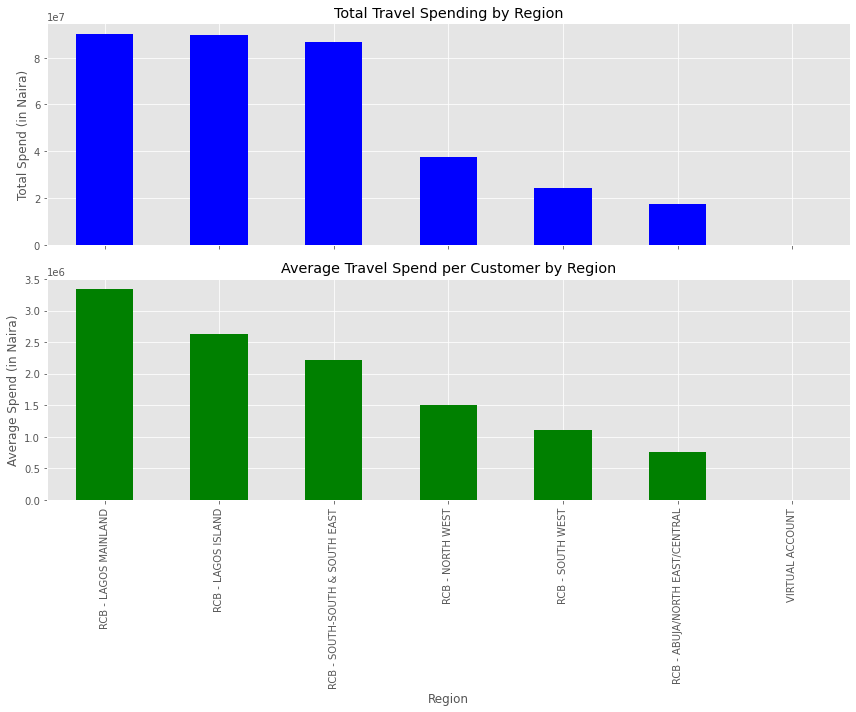

In [36]:
# Visualizing total travel spending and average spend per customer by region
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Bar plot for total travel spending
travel_habits_geo['Total Travel Spend'].sort_values(ascending=False).plot(
    kind='bar', ax=ax[0], color='blue', title='Total Travel Spending by Region'
)
ax[0].set_ylabel('Total Spend (in Naira)')
ax[0].set_xlabel('')

# Bar plot for average spend per customer
travel_habits_geo['Average Spend per Customer'].sort_values(ascending=False).plot(
    kind='bar', ax=ax[1], color='green', title='Average Travel Spend per Customer by Region'
)
ax[1].set_ylabel('Average Spend (in Naira)')
ax[1].set_xlabel('Region')

plt.tight_layout()
plt.show()


The two visualizations of travel spending across regions above are explained below:

- Total Travel Spending by Region: Shows the total amount spent on travel and hotels in each region.
- Average Travel Spend per Customer: Highlights the average travel expenditure for high spenders in each region.

#### Compare Shopping vs Travel Habit Regionally

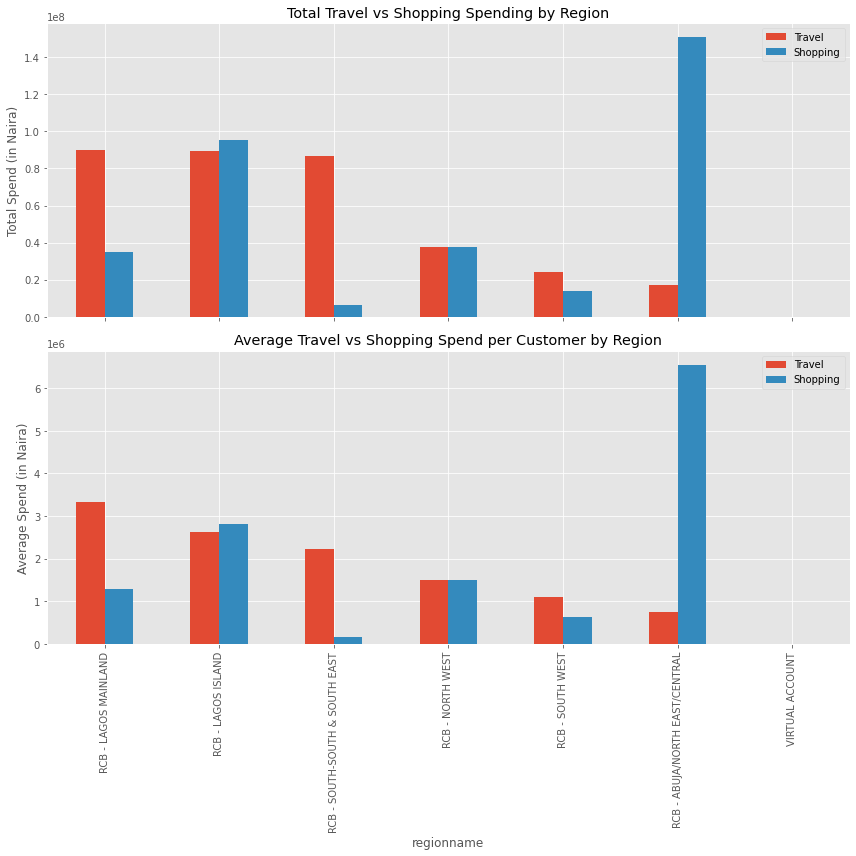

Regional Travel vs Shopping Comparison:


,Total_Travel_Spend,Total_Shopping_Spend,Customer_Count,Avg_Travel_Spend_per_Customer,Avg_Shopping_Spend_per_Customer
regionname,,,,,
RCB - ABUJA/NORTH EAST/CENTRAL,17341700.0,1.507137e+08,23,7.539870e+05,6.552768e+06
RCB - LAGOS ISLAND,89598780.0,9.553223e+07,34,2.635258e+06,2.809771e+06
RCB - LAGOS MAINLAND,90163884.0,3.482791e+07,27,3.339403e+06,1.289923e+06
RCB - NORTH WEST,37539100.0,3.747502e+07,25,1.501564e+06,1.499001e+06
RCB - SOUTH WEST,24316000.0,1.391798e+07,22,1.105273e+06,6.326352e+05
RCB - SOUTH-SOUTH & SOUTH EAST,86694694.0,6.249862e+06,39,2.222941e+06,1.602529e+05
VIRTUAL ACCOUNT,0.0,0.000000e+00,1,0.000000e+00,0.000000e+00


In [37]:
# Comparing travel and shopping spending across regions
travel_vs_shopping = high_spenders.groupby('regionname').agg(
    Total_Travel_Spend=('TransactionSumAmount_Travel_Hotel', 'sum'),
    Total_Shopping_Spend=('TransactionSumAmount_Shopping', 'sum'),
    Customer_Count=('CustomerID', 'count')
)

# Calculate average spend per customer for both categories
travel_vs_shopping['Avg_Travel_Spend_per_Customer'] = travel_vs_shopping['Total_Travel_Spend'] / travel_vs_shopping['Customer_Count']
travel_vs_shopping['Avg_Shopping_Spend_per_Customer'] = travel_vs_shopping['Total_Shopping_Spend'] / travel_vs_shopping['Customer_Count']

# Visualize the comparison
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Total spending comparison
travel_vs_shopping[['Total_Travel_Spend', 'Total_Shopping_Spend']].sort_values(by='Total_Travel_Spend', ascending=False).plot(
    kind='bar', ax=ax[0], title='Total Travel vs Shopping Spending by Region'
)
ax[0].set_ylabel('Total Spend (in Naira)')
ax[0].legend(['Travel', 'Shopping'])

# Average spending per customer comparison
travel_vs_shopping[['Avg_Travel_Spend_per_Customer', 'Avg_Shopping_Spend_per_Customer']].sort_values(by='Avg_Travel_Spend_per_Customer', ascending=False).plot(
    kind='bar', ax=ax[1], title='Average Travel vs Shopping Spend per Customer by Region'
)
ax[1].set_ylabel('Average Spend (in Naira)')
ax[1].legend(['Travel', 'Shopping'])

plt.tight_layout()
plt.show()

# Display regional travel vs shopping comparison
print("Regional Travel vs Shopping Comparison:")
travel_vs_shopping

# # Save the data to a CSV file for further analysis
# travel_vs_shopping.to_csv("Regional_Travel_vs_Shopping_Comparison.csv", index=False)

##### Key Insights:

`Total Spending:`

    - Abuja/North East/Central leads in shopping spend (over 150 million), while Lagos mainland shows the highest travel spending (over 90 million).
    - Lagos island balances both, with significant totals in travel (over 89 million) and shopping (over 95 million).

`Average Spend per Customer:`

    - Lagos Mainland has the highest average travel spend per customer (over 3.3 million) and a significant average shopping spend (1,289,923).
    - Abuja/North East/Central stands out for shopping, with an average spend per customer exceeding 6.5 million.

`Spending Patterns:`

    - Regions like South West have balanced spending, with moderate averages for both categories.

#### Analyze regional trends in gas spending.

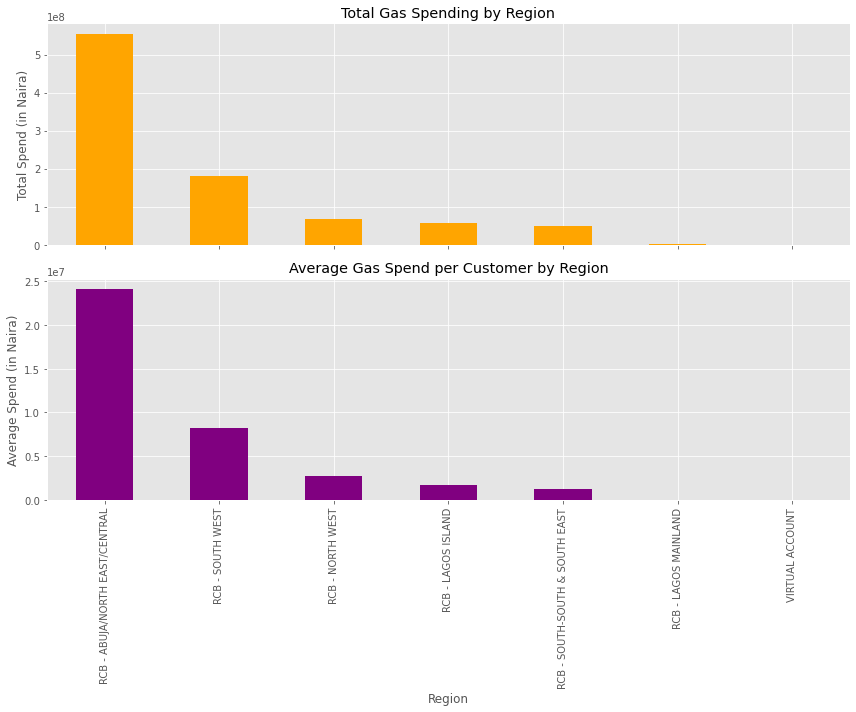

Regional Gas Spending Trends:


,Total_Gas_Spend,Customer_Count,Avg_Gas_Spend_per_Customer
regionname,,,
RCB - ABUJA/NORTH EAST/CENTRAL,5.543310e+08,23,2.410135e+07
RCB - LAGOS ISLAND,5.768938e+07,34,1.696746e+06
RCB - LAGOS MAINLAND,1.303325e+06,27,4.827130e+04
RCB - NORTH WEST,6.796735e+07,25,2.718694e+06
RCB - SOUTH WEST,1.810640e+08,22,8.230184e+06
RCB - SOUTH-SOUTH & SOUTH EAST,4.991131e+07,39,1.279777e+06
VIRTUAL ACCOUNT,4.050000e+04,1,4.050000e+04


In [38]:
# Group data by region and calculate total and average gas spending
gas_spending_by_region = high_spenders.groupby('regionname').agg(
    Total_Gas_Spend=('TransactionSumAmount_Gas', 'sum'),
    Customer_Count=('CustomerID', 'count')
)

# Calculate average gas spending per customer
gas_spending_by_region['Avg_Gas_Spend_per_Customer'] = gas_spending_by_region['Total_Gas_Spend'] / gas_spending_by_region['Customer_Count']

# Visualize gas spending
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Total gas spending by region
gas_spending_by_region['Total_Gas_Spend'].sort_values(ascending=False).plot(
    kind='bar', ax=ax[0], color='orange', title='Total Gas Spending by Region'
)
ax[0].set_ylabel('Total Spend (in Naira)')
ax[0].set_xlabel('')

# Average gas spending per customer by region
gas_spending_by_region['Avg_Gas_Spend_per_Customer'].sort_values(ascending=False).plot(
    kind='bar', ax=ax[1], color='purple', title='Average Gas Spend per Customer by Region'
)
ax[1].set_ylabel('Average Spend (in Naira)')
ax[1].set_xlabel('Region')

plt.tight_layout()
plt.show()

# Display regional gas spending trends
print("Regional Gas Spending Trends:")
gas_spending_by_region

# # Save the data to a CSV file for further analysis
# gas_spending_by_region.to_csv("Regional_Gas_Spending_Trends.csv", index=False)

##### Key Findings:

`Total Gas Spending:`

    - Abuja/North East/Central leads significantly, with over 554 million spent.
    - South West follows with ~181 million.
    - North West accounts for almost 68 million.

`Average Gas Spend per Customer:`

    - Abuja/North East/Central has the highest average gas spending per customer (~24 million).
    - South West and North West also show high averages (0ver 8.2 million and over 2.7 million, respectively).
    - Virtual Account shows the lowest average (~41,000).

#### Breakdown of average spending by regions.

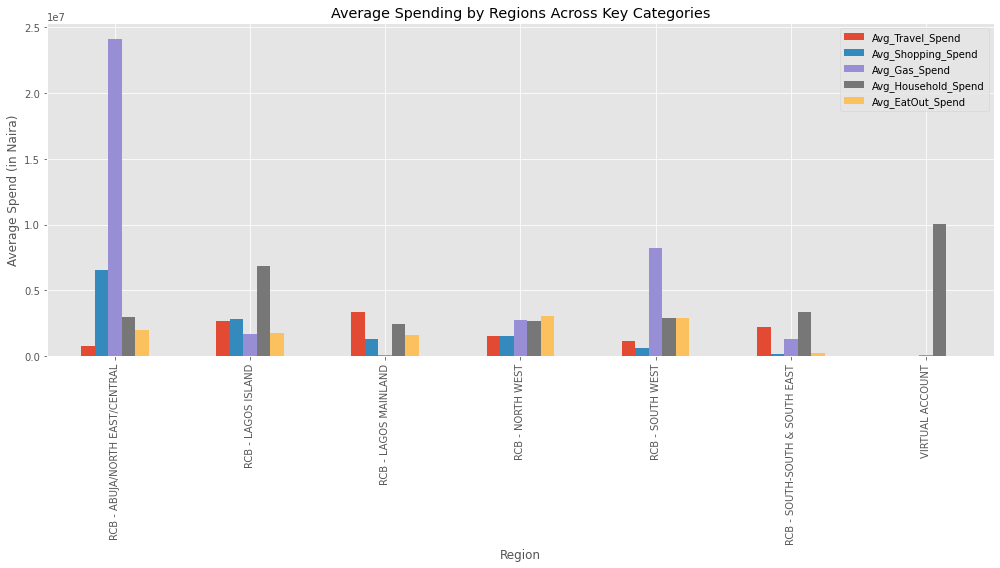

Regional Average Spending Breakdown:


,Avg_Travel_Spend,Avg_Shopping_Spend,Avg_Gas_Spend,Avg_Household_Spend,Avg_EatOut_Spend
regionname,,,,,
RCB - ABUJA/NORTH EAST/CENTRAL,7.539870e+05,6.552768e+06,2.410135e+07,2.993043e+06,1.945642e+06
RCB - LAGOS ISLAND,2.635258e+06,2.809771e+06,1.696746e+06,6.873524e+06,1.734155e+06
RCB - LAGOS MAINLAND,3.339403e+06,1.289923e+06,4.827130e+04,2.405378e+06,1.588034e+06
RCB - NORTH WEST,1.501564e+06,1.499001e+06,2.718694e+06,2.650880e+06,3.026236e+06
RCB - SOUTH WEST,1.105273e+06,6.326352e+05,8.230184e+06,2.918475e+06,2.909694e+06
RCB - SOUTH-SOUTH & SOUTH EAST,2.222941e+06,1.602529e+05,1.279777e+06,3.361624e+06,2.165041e+05
VIRTUAL ACCOUNT,0.000000e+00,0.000000e+00,4.050000e+04,1.005680e+07,9.000000e+03


In [39]:
# Calculating average spending per customer across all categories by region
average_spending_by_region = high_spenders.groupby('regionname').agg(
    Avg_Travel_Spend=('TransactionSumAmount_Travel_Hotel', 'mean'),
    Avg_Shopping_Spend=('TransactionSumAmount_Shopping', 'mean'),
    Avg_Gas_Spend=('TransactionSumAmount_Gas', 'mean'),
    Avg_Household_Spend=('TransactionSumAmount_Household', 'mean'),
    Avg_EatOut_Spend=('TransactionSumAmount_EatOut', 'mean')
)

# Visualize average spending by region
average_spending_by_region_plot = average_spending_by_region.plot(
    kind='bar', figsize=(14, 8), title='Average Spending by Regions Across Key Categories'
)

average_spending_by_region_plot.set_ylabel('Average Spend (in Naira)')
average_spending_by_region_plot.set_xlabel('Region')
plt.tight_layout()
plt.show()

# Display regional average spending breakdown
print("Regional Average Spending Breakdown:")
average_spending_by_region

# # Save the data to a CSV file for further analysis
# average_spending_by_region.to_csv("Regional_Average_Spending_Breakdown.csv", index=False)

##### Insights:

`Travel Spending:`

    - Lagos Mainland has the highest average travel spending (over 3.3 million), followed by LagosIsland (over 2.6 million).

`Shopping Spending:`
    
    - Abuja/North East/Central stands out with the highest average shopping spend (over 6.5 million per customer).

`Gas Spending:`

    - Abuja/North East/Central has the highest average gas spend (over 24 million), significantly outpacing other regions.

`Household Spending:`

    - North West and South West show strong household spending (over 3 million and ~2.9 million, respectively).

`EatOut Spending:`

    - North West leads in dining expenditures, with an average of ~3 million per customer.

#### Investigate entertainment spending patterns.

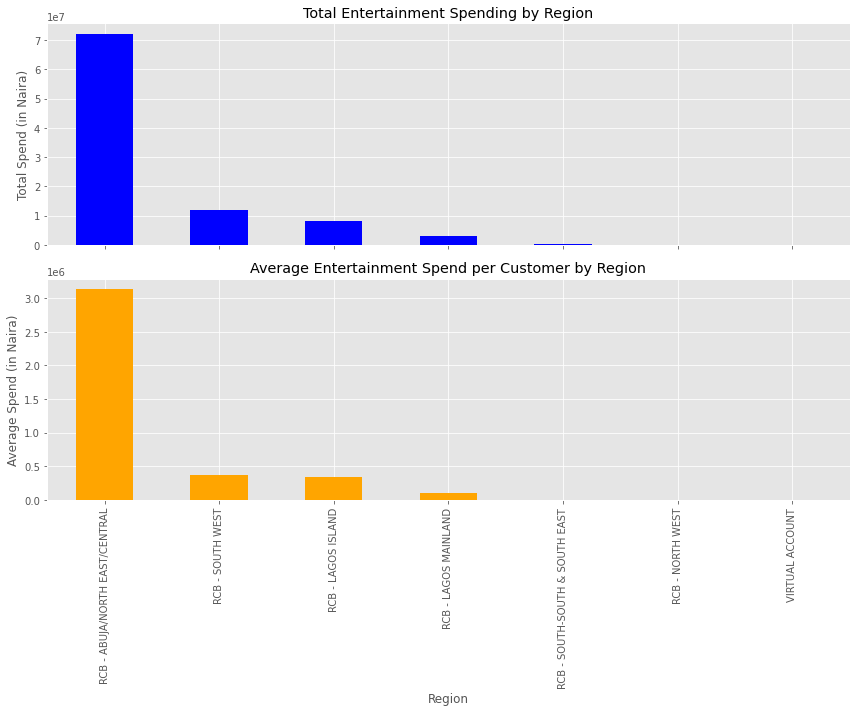

Entertainment Spending Patterns by Region:


,Total_Entertainment_Spend,Avg_Entertainment_Spend,Customer_Count
regionname,,,
RCB - ABUJA/NORTH EAST/CENTRAL,72122950.0,3.135780e+06,23
RCB - LAGOS ISLAND,11732500.0,3.450735e+05,34
RCB - LAGOS MAINLAND,2861000.0,1.059630e+05,27
RCB - NORTH WEST,5000.0,2.000000e+02,25
RCB - SOUTH WEST,7999300.0,3.636045e+05,22
RCB - SOUTH-SOUTH & SOUTH EAST,183300.0,4.700000e+03,39
VIRTUAL ACCOUNT,0.0,0.000000e+00,1


In [40]:
# Group data by region for entertainment spending
entertainment_spending_by_region = high_spenders.groupby('regionname').agg(
    Total_Entertainment_Spend=('TransactionSumAmount_Entertainment', 'sum'),
    Avg_Entertainment_Spend=('TransactionSumAmount_Entertainment', 'mean'),
    Customer_Count=('CustomerID', 'count')
)

# Visualize total and average entertainment spending by region
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Total entertainment spending by region
entertainment_spending_by_region['Total_Entertainment_Spend'].sort_values(ascending=False).plot(
    kind='bar', ax=ax[0], color='blue', title='Total Entertainment Spending by Region'
)
ax[0].set_ylabel('Total Spend (in Naira)')
ax[0].set_xlabel('')

# Average entertainment spending per customer
entertainment_spending_by_region['Avg_Entertainment_Spend'].sort_values(ascending=False).plot(
    kind='bar', ax=ax[1], color='orange', title='Average Entertainment Spend per Customer by Region'
)
ax[1].set_ylabel('Average Spend (in Naira)')
ax[1].set_xlabel('Region')

plt.tight_layout()
plt.show()

# Display entertainment spending patterns by region
print("Entertainment Spending Patterns by Region:")
entertainment_spending_by_region

# Save the data to a CSV file for further analysis
# entertainment_spending_by_region.to_csv("Entertainment_Spending_Patterns_By_Region.csv", index=False)

##### Insights:

`Total Entertainment Spending:`

    - Abuja/North East/Central leads with a total spend of ~72 million.
    - Lagos Island (~11.7 million) and South West (~8 million) follow as significant contributors.

`Average Entertainment Spending Per Customer:`

    - Abuja/North East/Central has the highest average spend per customer (~3,135,780), indicating higher individual investments in entertainment.
    - South West (~363,000) and Lagos Island (~345,700) show moderate spending levels.

`Customer Count:`

    - South-South & South East has the largest customer base (39), but with lower average spending compared to Abuja/North East/Central.

#### Analyze medium spenders' behaviors regionally.

In [41]:
# Filter medium spenders based on SpendingSegment
medium_spenders = data[data['SpendingSegment'] == 'Moderate Spender']

# Aggregate spending behaviors regionally for medium spenders
medium_spenders_behavior = medium_spenders.groupby('regionname').agg(
    Total_Spending=('TotalSpending', 'sum'),
    Average_Spending=('TotalSpending', 'mean'),
    Customer_Count=('CustomerID', 'count'),
)

# Include breakdown of top categories for regional analysis
medium_spenders_categories = medium_spenders.groupby('regionname').agg(
    {col: 'sum' for col in medium_spenders.columns if 'TransactionSumAmount_' in col}
)

# Combine overall spending and category details
medium_spenders_analysis = medium_spenders_behavior.join(medium_spenders_categories)

# Display the results for review
("\nMedium Spenders' Regional Behaviors:")
medium_spenders_analysis.sort_values(by='Total_Spending', ascending=False)

,Total_Spending,Average_Spending,Customer_Count,TransactionSumAmount_Animals_Agriculture,TransactionSumAmount_Betting/Gaming,TransactionSumAmount_Bills,TransactionSumAmount_EatOut,TransactionSumAmount_Entertainment,TransactionSumAmount_Fashion,TransactionSumAmount_Gas,...,TransactionSumAmount_Loan,TransactionSumAmount_ReligiousActivities,TransactionSumAmount_RideHailing,TransactionSumAmount_Savings/Investment,TransactionSumAmount_School,TransactionSumAmount_Shopping,TransactionSumAmount_Social,TransactionSumAmount_Transport,TransactionSumAmount_Travel_Hotel,TransactionSumAmount_Wellness
regionname,,,,,,,,,,,,,,,,,,,,,
RCB - SOUTH-SOUTH & SOUTH EAST,2.194034e+08,2.238810e+06,98,8655200.0,3000.0,2707242.0,8582420.00,7528021.80,13389440.5,12868080.00,...,10062000.0,12613450.0,1690159.84,15827398.00,7531100.00,20314837.73,33556800.0,6446300.0,16321365.00,6377559.08
RCB - LAGOS MAINLAND,1.618446e+08,2.312065e+06,70,3823743.0,6190300.0,3221974.0,29329992.25,9096287.50,4298600.0,5230622.69,...,11470000.0,12249230.0,201635.00,6213335.71,4393882.00,11091924.06,11114986.0,1776430.0,10374437.50,5202299.60
RCB - LAGOS ISLAND,1.517202e+08,2.167432e+06,70,4845400.0,12200.0,1683850.0,13132692.30,6939678.75,6749500.0,8883485.95,...,7114510.0,7762550.0,872723.56,12075774.00,7909898.09,16435495.66,11487990.0,1108700.0,17006452.12,2939974.20
RCB - SOUTH WEST,1.062734e+08,2.310292e+06,46,4520000.0,50000.0,4532050.0,11524560.00,4451500.00,2481400.0,6529093.89,...,8980000.0,4220250.0,65301.92,9276854.00,2271100.00,14277204.00,16418000.0,1437000.0,3844077.08,2553550.00
RCB - ABUJA/NORTH EAST/CENTRAL,1.005493e+08,2.452423e+06,41,6600000.0,1922000.0,1114797.0,6621720.00,1239300.00,1861700.0,7889491.22,...,5840000.0,6630500.0,166999.00,3979400.00,4733107.70,11135773.76,5891912.5,5671000.0,12152800.00,1964237.00
RCB - NORTH WEST,2.630754e+07,1.644222e+06,16,4700000.0,0.0,0.0,2871400.00,71900.00,44550.0,70375.00,...,1550000.0,120000.0,50000.00,1000000.00,522150.00,2583330.00,1199000.0,970000.0,5671744.00,1674146.00


Regional Spending Trends:

`Top Regions by Total Spending:`

    - South-South & South East: Leads with a total spending of ~₦219.4 million.
    - Lagos Mainland: Second-highest at ~₦161.844 million.
    - Lagos Island: Close behind with ~₦151.72 million.

`Customer Count:`

    - South-South & South East has the largest number of medium spenders (98 customers), reflecting widespread moderate spending.

`Category Preferences:`

    - Gas, Shopping, and EatOut are consistently high across all regions.
    - South-South & South East and Lagos Island lead in Shopping, with spending over ₦20 million and ₦11 million each.

`Average Spending per Customer:`

    - Abuja/North East/Central has the highest average spending per customer (~₦2,452,423), despite having fewer customers.

#### Analyze travel habits of medium spenders.

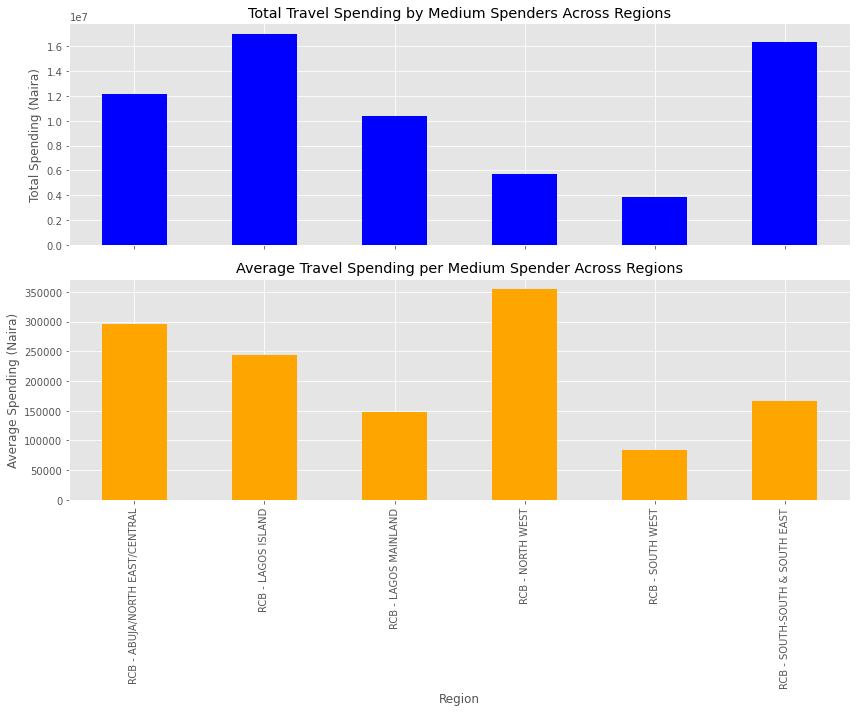


Medium Spenders' Travel Habits:


,Total_Travel_Spending,Average_Travel_Spending,Customer_Count
regionname,,,
RCB - LAGOS ISLAND,17006452.12,242949.316000,70
RCB - SOUTH-SOUTH & SOUTH EAST,16321365.00,166544.540816,98
RCB - ABUJA/NORTH EAST/CENTRAL,12152800.00,296409.756098,41
RCB - LAGOS MAINLAND,10374437.50,148206.250000,70
RCB - NORTH WEST,5671744.00,354484.000000,16
RCB - SOUTH WEST,3844077.08,83566.893043,46


In [42]:
# Analyze travel habits of medium spenders
medium_spenders_travel = medium_spenders.groupby('regionname').agg(
    Total_Travel_Spending=('TransactionSumAmount_Travel_Hotel', 'sum'),
    Average_Travel_Spending=('TransactionSumAmount_Travel_Hotel', 'mean'),
    Customer_Count=('CustomerID', 'count')
)

# Visualizing travel spending for medium spenders
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Total travel spending by region
medium_spenders_travel['Total_Travel_Spending'].plot(
    kind='bar', ax=ax[0], color='blue', title='Total Travel Spending by Medium Spenders Across Regions'
)
ax[0].set_ylabel('Total Spending (Naira)')

# Average travel spending per customer by region
medium_spenders_travel['Average_Travel_Spending'].plot(
    kind='bar', ax=ax[1], color='orange', title='Average Travel Spending per Medium Spender Across Regions'
)
ax[1].set_ylabel('Average Spending (Naira)')
ax[1].set_xlabel('Region')

plt.tight_layout()
plt.show()

# Display data for medium spenders' travel habits
print("\nMedium Spenders' Travel Habits:")
medium_spenders_travel.sort_values(by='Total_Travel_Spending', ascending=False)

Travel Habits of Medium Spenders:

`Total Travel Spending by Region:`

    - Lagos Island leads with total spending of approximately ₦17006452.12.
    - South-South & South East follows closely with ₦16321365.00.
    - ABUJA/NORTH EAST/CENTRAL ranks third at ₦12152800.00.

`Average Travel Spending Per Customer:`

    - North West medium spenders exhibit the highest average spending at ₦354,484 per customer.
    - Lagos Island, South-South & South East and ABUJA/NORTH EAST/CENTRAL show average spends of ₦242,949.32, ₦166,544.54 and ₦296,409.76 respectively.
    - South West displays the lowest average at ₦83,566.89 per customer.

`Customer Count:`

    - South-South & South East has the largest number of medium spenders (98 customers), reflecting broad participation in travel-related spending.
    - Lagos Island and Lagos Mainland follow with 70 and 70 customers, respectively.

#### How do medium spenders prioritize categories?

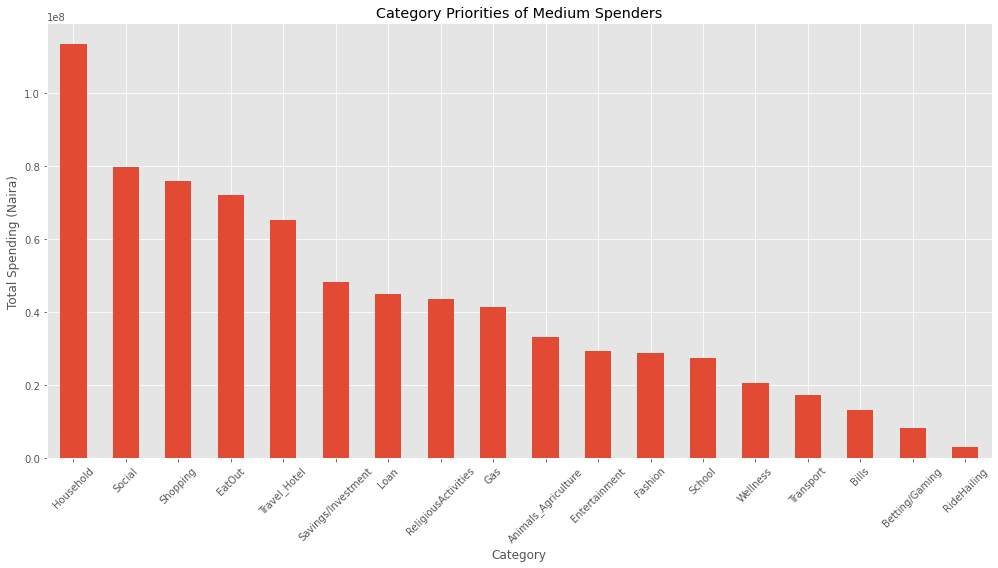


Medium Spenders' Category Priorities:


Household              1.134383e+08
Social                 7.966869e+07
Shopping               7.583857e+07
EatOut                 7.206278e+07
Travel_Hotel           6.537088e+07
Savings/Investment     4.837276e+07
Loan                   4.501651e+07
ReligiousActivities    4.359598e+07
Gas                    4.147115e+07
Animals_Agriculture    3.314434e+07
Entertainment          2.932669e+07
Fashion                2.882519e+07
School                 2.736124e+07
Wellness               2.071177e+07
Transport              1.740943e+07
Bills                  1.325991e+07
Betting/Gaming         8.177500e+06
RideHailing            3.046819e+06
dtype: float64

In [43]:
# Aggregating spending across categories for medium spenders
medium_spenders_category_priorities = medium_spenders.filter(like='TransactionSumAmount_').sum().sort_values(ascending=False)

# Cleaning category names for readability
medium_spenders_category_priorities.index = medium_spenders_category_priorities.index.str.replace('TransactionSumAmount_', '')

# Visualizing category priorities for medium spenders
plt.figure(figsize=(14, 8))
medium_spenders_category_priorities.plot(
    kind='bar', title='Category Priorities of Medium Spenders', ylabel='Total Spending (Naira)', xlabel='Category'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display detailed data for category spending
print("\nMedium Spenders' Category Priorities:")
medium_spenders_category_priorities

Medium Spenders' Category Priorities:

`Top Categories by Total Spending:`

    - Household: Dominates with a total spending of ₦113,438,300, reflecting its importance for daily needs.
    - Social: Second-highest at ₦79,668,690, indicating strong consumer activity.
    - Shopping: Significant spending of ₦75,838,570 highlighting shopping preferences.

`Additional Key Categories:`

    - EatOut: Total spending of ₦72,062,780, showcasing dining interests.
    - Travel/Hotel: Spending of ₦65,370,880, indicating moderate engagement in travel.
    - Savings/Investment: Close totals (₦48,372,760), reflecting investment/savings expenditures.

`Specialized Categories:`

    - Loan: A notable category with ₦45,016,510 million.
    - Religious Activities: Moderate spending at ₦43,595,980 million.

#### Which category shows most regional diversity?

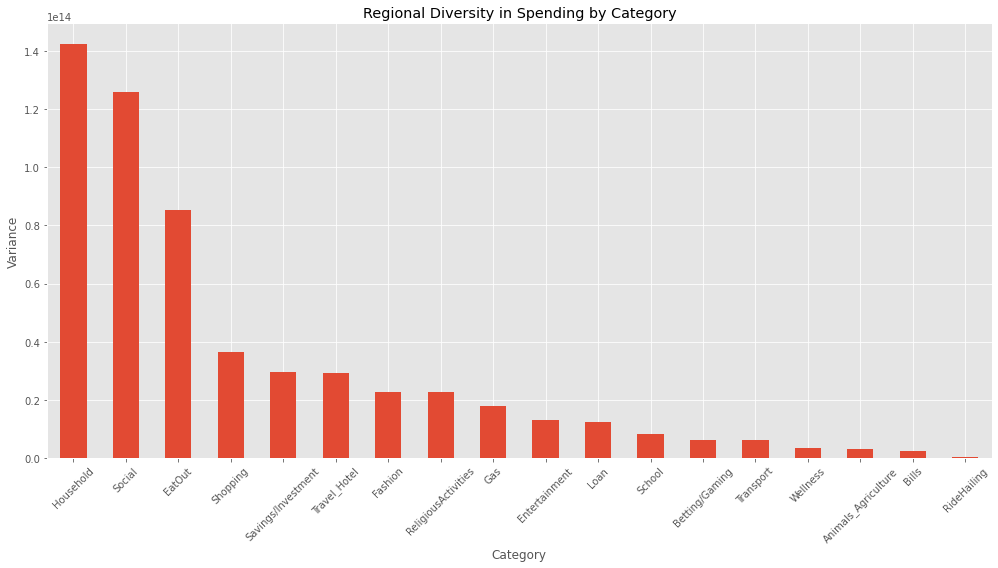

Regional Diversity by Category:


Animals_Agriculture    3.200111e+12
Betting/Gaming         6.174261e+12
Bills                  2.604732e+12
EatOut                 8.515482e+13
Entertainment          1.311743e+13
Fashion                2.289083e+13
Gas                    1.801972e+13
Household              1.423144e+14
Loan                   1.256436e+13
ReligiousActivities    2.288403e+13
RideHailing            4.292823e+11
Savings/Investment     2.956894e+13
School                 8.330022e+12
Shopping               3.635704e+13
Social                 1.258857e+14
Transport              6.118221e+12
Travel_Hotel           2.912925e+13
Wellness               3.613206e+12
dtype: float64

In [44]:
# Calculate the spending variance across regions for each category to measure regional diversity
category_regional_diversity = medium_spenders.groupby('regionname').agg(
    {col: 'sum' for col in medium_spenders.columns if 'TransactionSumAmount_' in col}
).var()

# Cleaning category names for readability
category_regional_diversity.index = category_regional_diversity.index.str.replace('TransactionSumAmount_', '')

# Identify the category with the highest variance
most_diverse_category = category_regional_diversity.idxmax()
highest_variance = category_regional_diversity.max()

# Visualizing regional diversity across categories
plt.figure(figsize=(14, 8))
category_regional_diversity.sort_values(ascending=False).plot(
    kind='bar', title='Regional Diversity in Spending by Category', ylabel='Variance', xlabel='Category'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display regional diversity by category
print("Regional Diversity by Category:")
category_regional_diversity

In [45]:
# # Save the data to a CSV file for further analysis
# category_regional_diversity.to_csv("Regional_Diversity_By_Category.csv", index=False)

# Display most diverse category and highest variance
print("\nMost Diverse Category:")
most_diverse_category


Most Diverse Category:


'Household'

#### Analyze trends in education-related spending.

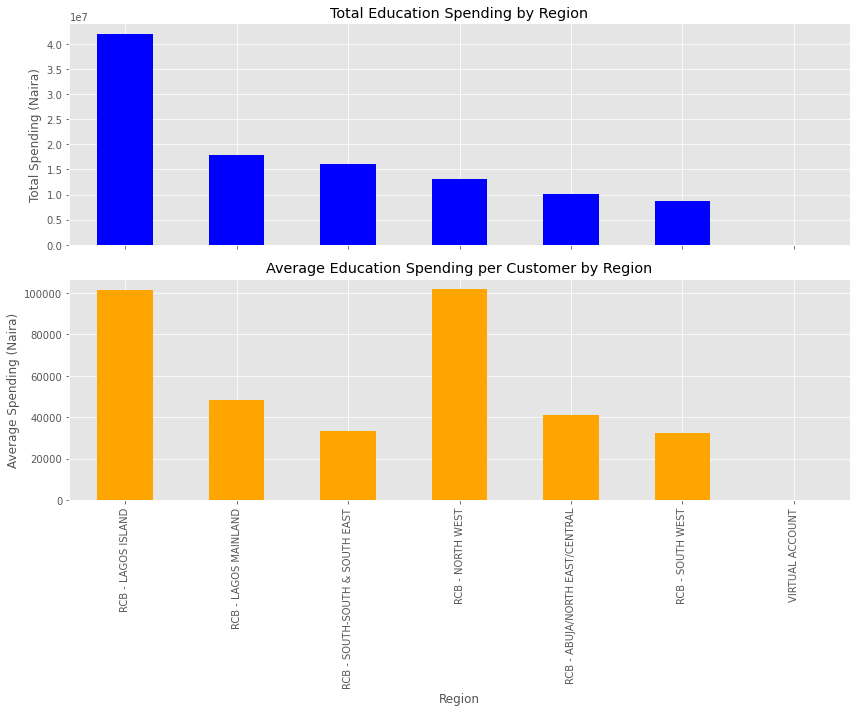

Education Spending Analysis by Region:


,Total Education Spending,Average Education Spending
regionname,,
RCB - LAGOS ISLAND,42013099.20,101480.915942
RCB - LAGOS MAINLAND,17839583.45,48477.128940
RCB - SOUTH-SOUTH & SOUTH EAST,16030639.56,33189.729938
RCB - NORTH WEST,13142686.81,101881.293101
RCB - ABUJA/NORTH EAST/CENTRAL,10151879.20,40934.996774
RCB - SOUTH WEST,8749939.99,32168.897022
VIRTUAL ACCOUNT,0.00,0.000000


In [46]:
# Aggregate education-related spending across all regions
education_spending_by_region = data.groupby('regionname')['TransactionSumAmount_School'].sum()

# Calculate average education spending per customer
education_avg_spending = data.groupby('regionname')['TransactionSumAmount_School'].mean()

# Combine total and average spending for display
education_spending_analysis = pd.DataFrame({
    'Total Education Spending': education_spending_by_region,
    'Average Education Spending': education_avg_spending
}).sort_values(by='Total Education Spending', ascending=False)

# Visualize education-related spending
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Total education spending by region
education_spending_analysis['Total Education Spending'].plot(
    kind='bar', ax=ax[0], color='blue', title='Total Education Spending by Region'
)
ax[0].set_ylabel('Total Spending (Naira)')

# Average education spending per customer by region
education_spending_analysis['Average Education Spending'].plot(
    kind='bar', ax=ax[1], color='orange', title='Average Education Spending per Customer by Region'
)
ax[1].set_ylabel('Average Spending (Naira)')
ax[1].set_xlabel('Region')

plt.tight_layout()
plt.show()

# Display education spending analysis by region
print("Education Spending Analysis by Region:")
education_spending_analysis

# Save the data to a CSV file for further analysis
# education_spending_analysis.to_csv("Education_Spending_Analysis_By_Region.csv", index=False)

Education-Related Spending Trends:

`1. Total Spending by Region:`

    - Lagos Island leads with total spending of approximately ₦42.01 million, indicating significant investment in education.
    - Lagos Mainland follows at ₦17.84 million, with South-South & South East ranking third at ₦16.03 million.
    - North West and Abuja/North East/Central also show notable education-related spending (~₦13.14 million and ₦10.15 million, respectively).

`2. Average Spending Per Customer:`

    - North West has the highest average spending per customer at ₦101,881, reflecting concentrated high-value transactions.
    - Lagos Island follows closely with ₦101,480, indicating significant per-capita contributions.
    - Regions like South-South & South East and South West show moderate averages (~₦33,189 and ₦32,168, respectively).

`3. Observations:`

    - Lagos regions dominate, both in total and average spending, emphasizing their focus on educational investments.
    - North West displays a smaller customer base with high average spending, suggesting a concentrated but impactful educational priority.

### Customer Profiling

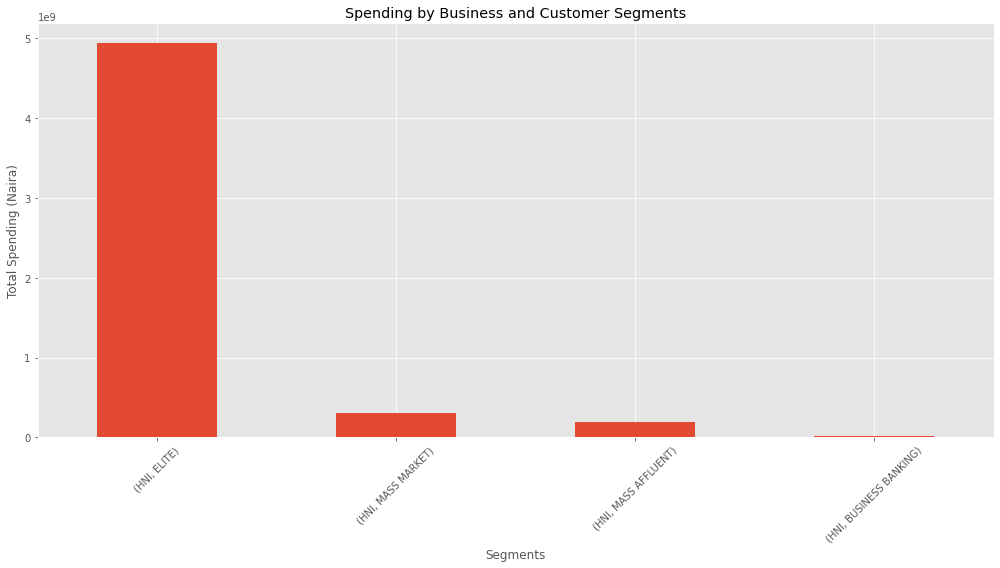

In [47]:
# calculate TotalSpending
if 'TotalSpending' not in data.columns:
    spending_columns = data.filter(like='TransactionSumAmount_').columns
    data['TotalSpending'] = data[spending_columns].sum(axis=1)

# Plot segment behavior analysis
segment_behavior = data.groupby(['recommended_business_segment', 'segments']).agg(
    Total_Spending=('TotalSpending', 'sum'),
    Average_Spending=('TotalSpending', 'mean'),
    Customer_Count=('CustomerID', 'count')
).sort_values(by='Total_Spending', ascending=False)

# Visualize Spending by Business and Customer Segments
segment_behavior_sorted = segment_behavior.sort_values(by='Total_Spending', ascending=False)
plt.figure(figsize=(14, 8))
segment_behavior_sorted['Total_Spending'].plot(
    kind='bar', title='Spending by Business and Customer Segments', ylabel='Total Spending (Naira)', xlabel='Segments'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


`Segment Behavior:`

- The Bar chart above showcases total spending by business and customer segments (e.g., HNI, Mass Affluent, Mass Market).

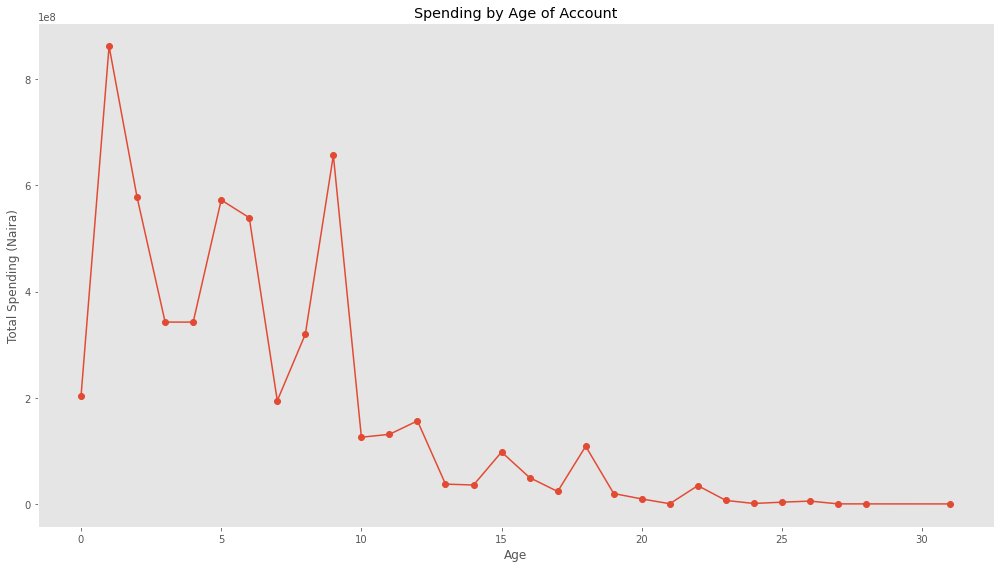

In [48]:
# Age of account Analysis (if available)
if 'acct_open_date' in data.columns:
    data['acct_open_date'] = pd.to_datetime(data['acct_open_date'], errors='coerce')
    data['Age_of_Customer_Account'] = (pd.Timestamp.now() - data['acct_open_date']).dt.days // 365
    age_analysis = data.groupby('Age_of_Customer_Account')['TotalSpending'].sum()

    plt.figure(figsize=(14, 8))
    age_analysis.plot(kind='line', marker='o', title='Spending by Age of Account', ylabel='Total Spending (Naira)', xlabel='Age')
    plt.grid()
    plt.tight_layout()
    plt.show()

`Age-Related Patterns:`
    
The Line chart above displays total spending across age groups of accounts.


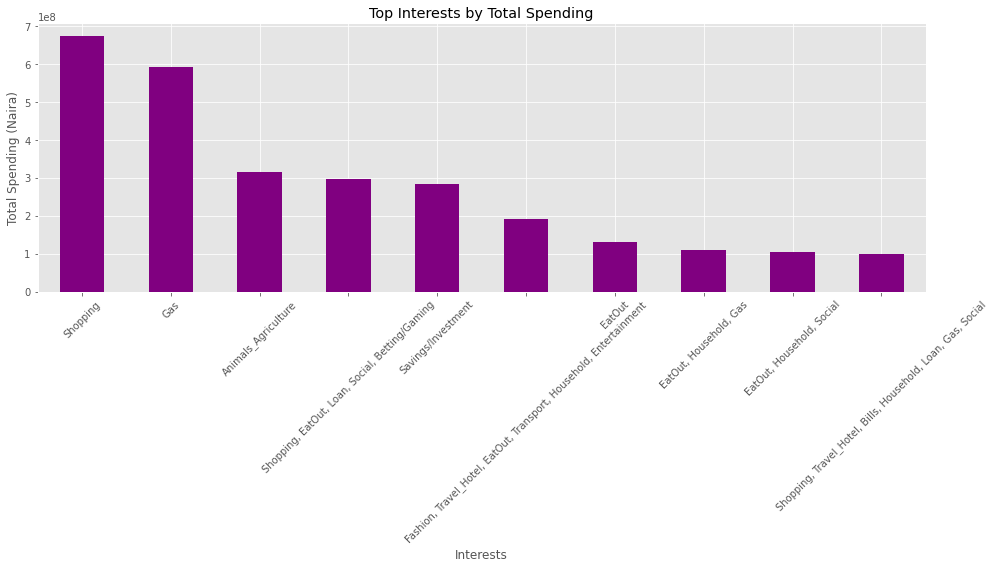

In [49]:
# Top Interests Spending
psychographics = data.groupby('SpendInterests').agg(
    Total_Spending=('TotalSpending', 'sum'),
    Customer_Count=('CustomerID', 'count')
).sort_values(by='Total_Spending', ascending=False)
psychographics_sorted = psychographics.head(10)

plt.figure(figsize=(14, 8))
psychographics_sorted['Total_Spending'].plot(
    kind='bar', color='purple', title='Top Interests by Total Spending', ylabel='Total Spending (Naira)', xlabel='Interests'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Psychographics:`

The Bar chart above illustrates top interests and their corresponding total spending, focusing on categories like Shopping, Gas, and EatOut.

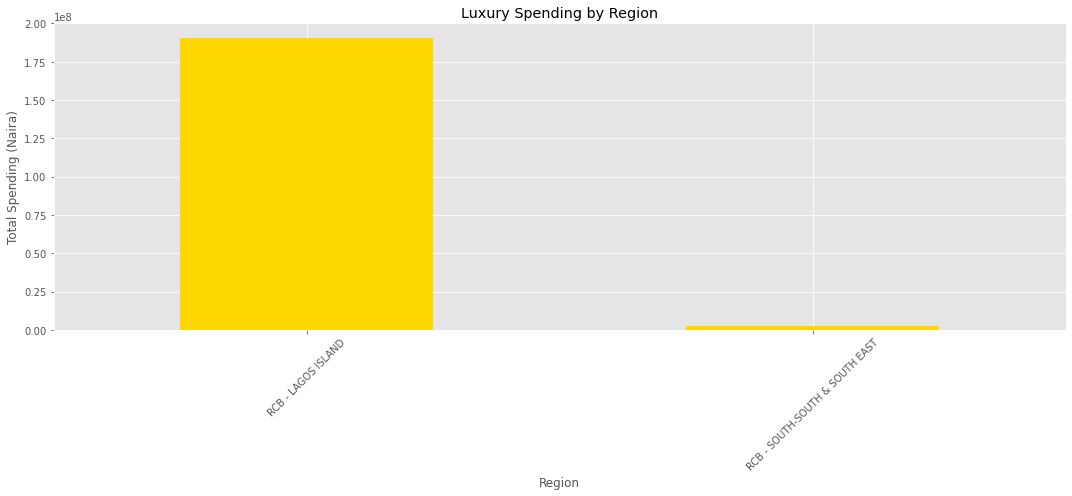

In [50]:
# Luxury Spender Analysis
luxury_spender_criteria = (
    (data['TransactionSumAmount_Travel_Hotel'] > data['TransactionSumAmount_Travel_Hotel'].mean()) &
    (data['TransactionSumAmount_Fashion'] > data['TransactionSumAmount_Fashion'].mean()) &
    (data['TransactionSumAmount_Entertainment'] > data['TransactionSumAmount_Entertainment'].mean())
)
luxury_spenders = data[luxury_spender_criteria]
luxury_spender_profile = luxury_spenders.groupby('regionname').agg(
    Total_Luxury_Spending=('TotalSpending', 'sum'),
    Average_Luxury_Spending=('TotalSpending', 'mean'),
    Customer_Count=('CustomerID', 'count')
).sort_values(by='Total_Luxury_Spending', ascending=False)

plt.figure(figsize=(15, 7))
luxury_spender_profile['Total_Luxury_Spending'].plot(
    kind='bar', color='gold', title='Luxury Spending by Region', ylabel='Total Spending (Naira)', xlabel='Region'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Luxury Spenders:`
    
The Bar chart above visualizes regional luxury spending, highlighting key regions such as Lagos Island and South-South & South East.

### Retention and Loyalty Analysis

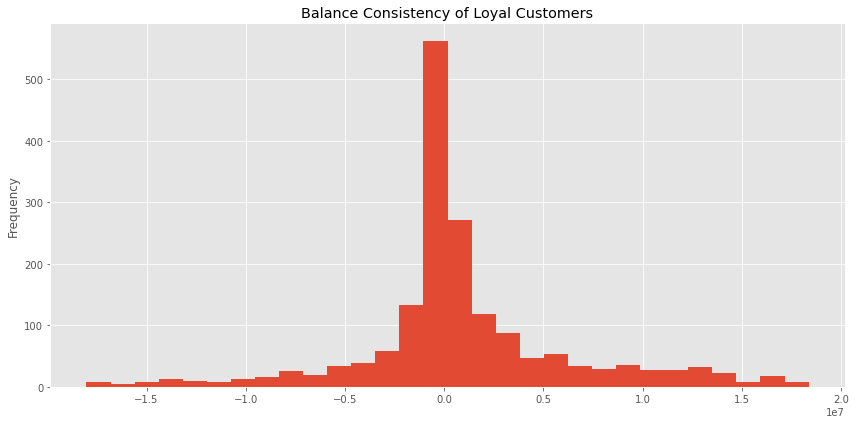

In [51]:
# 1. Identify Loyal Customers: Consistent spending (averagebal_august vs. actualbal_august)
# Calculate the difference between average and actual balances to measure consistency
data['balance_consistency'] = data['averagebal_august'] - data['actualbal_august']

# Classify customers as loyal based on low variance in balance
loyal_customers = data[data['balance_consistency'].abs() < data['balance_consistency'].std()]

# Visualize loyal customers' distribution
plt.figure(figsize=(12, 6))
loyal_customers['balance_consistency'].plot(
    kind='hist', bins=30, title='Balance Consistency of Loyal Customers', xlabel='Balance Consistency', ylabel='Frequency'
)
plt.tight_layout()
plt.show()

In [52]:
loyal_customers[['CustomerID', 'balance_consistency']]

,CustomerID,balance_consistency
0,20448.0,-968230.0
1,21076.0,-16906887.0
2,21896.0,-27632.0
3,26346.0,-85595.0
4,30585.0,1577689.0
...,...,...
1912,16628616.0,8764176.0
1913,16633468.0,14586567.0
1914,16637897.0,3226641.0
1915,16662159.0,613027.0


Loyal Customers have been identified based on consistent spending measured by comparing averagebal_august and actualbal_august.

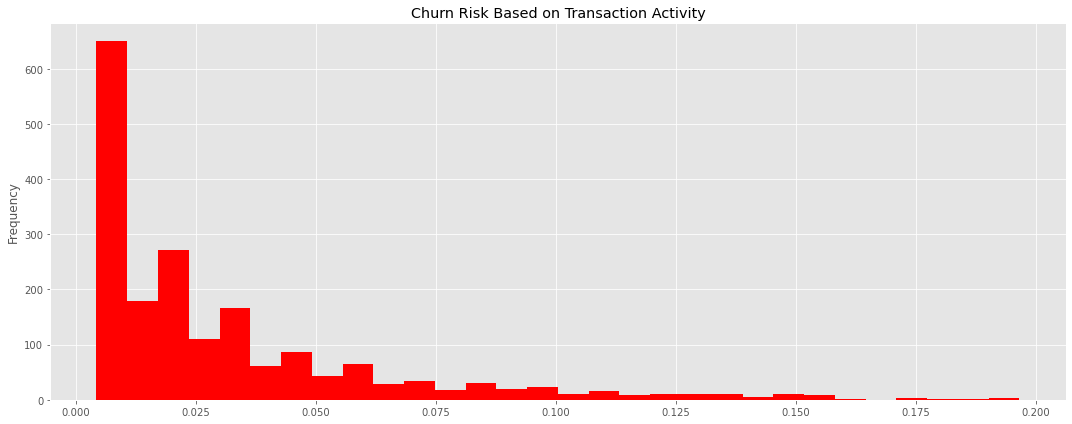

In [53]:
# 2. Determine Churn Risk: Customers with low or declining transaction activity
# Calculate transaction activity trend
transaction_activity = data.filter(like='TransactionCount_').sum(axis=1)
data['activity_trend'] = transaction_activity / transaction_activity.max()

# Identify customers at risk of churn
churn_risk = data[data['activity_trend'] < 0.2]  # Low activity threshold

# Visualize churn risk
plt.figure(figsize=(15, 6))
churn_risk['activity_trend'].plot(
    kind='hist', bins=30, color='red', title='Churn Risk Based on Transaction Activity', xlabel='Activity Trend', ylabel='Frequency'
)
plt.tight_layout()
plt.show()

In [54]:
churn_risk[['CustomerID', 'activity_trend']]

,CustomerID,activity_trend
0,20448.0,0.008547
1,21076.0,0.055556
2,21896.0,0.008547
3,26346.0,0.021368
4,30585.0,0.059829
...,...,...
1912,16628616.0,0.064103
1913,16633468.0,0.012821
1914,16637897.0,0.004274
1915,16662159.0,0.025641


Churn Risk: Customers with low or declining transaction activity (activity trend below 20% of the maximum) were flagged.

### Pyschographic Insight

Psychographics is the qualitative methodology of studying consumers based on psychological characteristics and traits such as values, social status, desires, goals, interests, and lifestyle choices. Psychographics analysis focuses on interests and behaviors

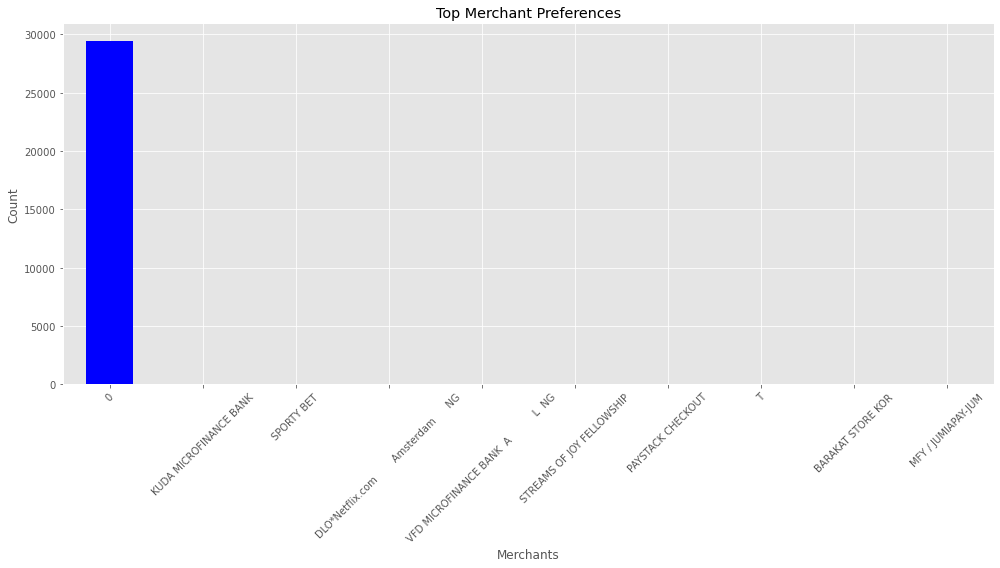

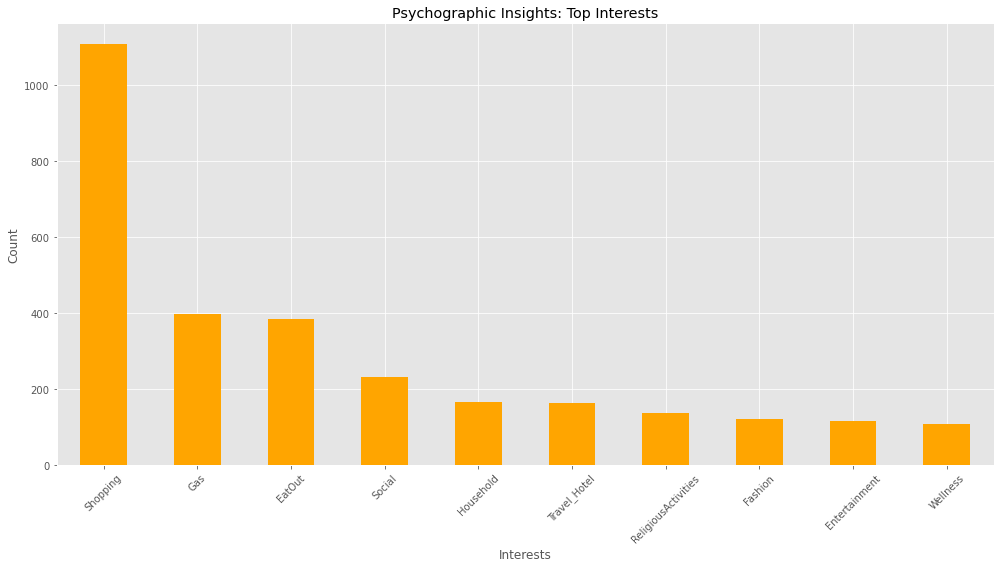

In [55]:
# Psychographic Insights Analysis

# Grouping customers by top merchant preferences and SpendInterests
top_merchants = data.filter(like='TopMerchant_').columns
merchant_preferences = data[top_merchants].apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False)

# Psychographic spending (SpendInterests)
spend_interest_counts = data['SpendInterests'].dropna().str.split(', ').explode().value_counts()

# Plot merchant preferences
plt.figure(figsize=(14, 8))
merchant_preferences.head(10).plot(
    kind='bar', title='Top Merchant Preferences', ylabel='Count', xlabel='Merchants', color='blue'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot SpendInterests
plt.figure(figsize=(14, 8))
spend_interest_counts.head(10).plot(
    kind='bar', title='Psychographic Insights: Top Interests', ylabel='Count', xlabel='Interests', color='orange'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
merchant_preferences.head(10)

0                                           29475.0
KUDA MICROFINANCE BANK                         54.0
SPORTY BET                                     28.0
DLO*Netflix.com        Amsterdam      NG       26.0
VFD MICROFINANCE BANK  A           L  NG       24.0
STREAMS OF JOY FELLOWSHIP                      23.0
PAYSTACK CHECKOUT                              10.0
T                                              10.0
BARAKAT STORE KOR                               9.0
MFY / JUMIAPAY-JUM                              9.0
dtype: float64

`Top Merchant Preferences`:

The bar chart above highlights the top 10 merchants based on customer preferences.

`Psychographic Insights`:

The bar chart above showcases the top 10 interests such as Social, Religious Activities, and Shopping, extracted from the SpendInterests column.

`Key Motivators`:

The bar chart above illustrates the counts of motivations such as Luxury, Convenience, and Necessity, inferred from the SpendInterests data.

#### Analyze psychographics by geographic regions

In [57]:
# Analyzing psychographics by geographic regions
# Extract and count SpendInterests for each region
psychographics_by_region = (
    data.groupby('regionname')['SpendInterests']
    .apply(lambda x: x.dropna().str.split(', ').explode().value_counts())
    .unstack(fill_value=0)
)

# Display psychographics by geographic region
print("Psychographics by Geographic Region:")
psychographics_by_region

# Save the data to a CSV file for further analysis
# psychographics_by_region.to_csv("Psychographics_By_Geographic_Region.csv", index=False)


Psychographics by Geographic Region:


,Animals_Agriculture,Betting/Gaming,Bills,EatOut,Entertainment,Fashion,Gas,Household,Loan,ReligiousActivities,RideHailing,Savings/Investment,School,Shopping,Social,Transport,Travel_Hotel,Wellness
regionname,,,,,,,,,,,,,,,,,,
RCB - ABUJA/NORTH EAST/CENTRAL,6,2,10,47,14,13,56,18,5,12,5,4,14,159,20,9,18,18
RCB - LAGOS ISLAND,8,3,16,102,33,35,108,42,11,43,10,23,30,236,50,17,42,24
RCB - LAGOS MAINLAND,7,9,18,82,22,21,77,30,5,27,5,10,14,196,61,9,29,18
RCB - NORTH WEST,7,0,2,11,4,6,15,10,1,1,1,3,4,87,7,2,9,9
RCB - SOUTH WEST,6,1,10,47,15,13,50,19,6,19,2,8,11,157,32,6,19,12
RCB - SOUTH-SOUTH & SOUTH EAST,10,9,19,95,29,35,92,46,10,36,2,18,20,269,62,13,47,27
VIRTUAL ACCOUNT,0,0,0,1,0,0,1,1,0,0,0,0,0,2,0,0,0,0


The psychographic analysis by geographic region reveals distinct interests and behaviors:

##### Key Findings:

`Top Interests by Region:`

- Lagos Island:
    - Leads in RideHailing (10 mentions), Gas (108), Entertainment(33) and EatOut (102).
- South-South & South East:
    - Strong interests in Shopping (269), Social activities (62), and EatOut (95).

`Emerging Trends:`

- North West:
    - Lower engagement but with consistent interests in Shopping (87).
- South West:
    - Balanced preferences across Shopping (157), EatOut (47), and Social activities (32).

`Specialized Categories:`

    - Travel/Hotel and Savings/Investment show significant interest in regions like LagosIsland and South-South & SouthEast.

#### Analyze spending habits in specific regions

In [58]:
# Aggregating spending habits across all categories for each region
spending_by_region = data.groupby('regionname').agg(
    {col: 'sum' for col in data.columns if 'TransactionSumAmount_' in col}
)

# Adding a total spending column
spending_by_region['Total_Spending'] = spending_by_region.sum(axis=1)

# Display spending habits by region
print("Regional Spending Habits:")
spending_by_region.sort_values(by='Total_Spending', ascending=False)

# Save the data to a CSV file for further analysis
# spending_by_region.to_csv("Regional_Spending_Habits.csv", index=False)

Regional Spending Habits:


,TransactionSumAmount_Animals_Agriculture,TransactionSumAmount_Betting/Gaming,TransactionSumAmount_Bills,TransactionSumAmount_EatOut,TransactionSumAmount_Entertainment,TransactionSumAmount_Fashion,TransactionSumAmount_Gas,TransactionSumAmount_Household,TransactionSumAmount_Loan,TransactionSumAmount_ReligiousActivities,TransactionSumAmount_RideHailing,TransactionSumAmount_Savings/Investment,TransactionSumAmount_School,TransactionSumAmount_Shopping,TransactionSumAmount_Social,TransactionSumAmount_Transport,TransactionSumAmount_Travel_Hotel,TransactionSumAmount_Wellness,Total_Spending
regionname,,,,,,,,,,,,,,,,,,,
RCB - ABUJA/NORTH EAST/CENTRAL,3.790288e+07,217660500.0,3008697.00,54692191.29,74347993.00,39803349.0,5.684313e+08,8.885019e+07,8371000.0,8145600.0,363099.00,1.364039e+07,10151879.20,1.679575e+08,11390112.5,61670100.0,3.219430e+07,5594661.32,1.404176e+09
RCB - LAGOS ISLAND,6.119024e+07,159700.0,22425468.99,77120962.48,20715345.96,17348205.6,7.568325e+07,2.684497e+08,55257510.0,25439850.0,2064916.12,1.838771e+08,42013099.20,1.248030e+08,43958490.0,7014200.0,1.130798e+08,7856522.04,1.148457e+09
RCB - SOUTH-SOUTH & SOUTH EAST,3.782902e+07,5816970.0,40526912.00,24155136.27,10794821.80,37629200.5,7.126453e+07,1.726535e+08,54264000.0,23214362.0,2043459.84,1.632659e+08,16030639.56,3.689948e+07,72875350.0,8103150.0,1.087393e+08,20078551.73,9.061843e+08
RCB - SOUTH WEST,1.529538e+08,623910.0,8331725.00,78708551.00,14233666.00,21057100.0,1.913516e+08,7.777221e+07,37880000.0,13068145.0,114091.92,4.321295e+07,8749939.99,3.732058e+07,23012618.0,6295910.0,3.034536e+07,3571869.00,7.486040e+08
RCB - LAGOS MAINLAND,3.644828e+07,10183300.0,43571158.01,77001504.09,14164418.50,42401491.5,1.160246e+07,9.636335e+07,22566500.0,46927770.0,311961.58,4.474450e+07,17839583.45,5.605751e+07,55879386.0,2647630.0,1.059380e+08,8310416.85,6.929593e+08
RCB - NORTH WEST,1.493028e+08,0.0,1112700.00,79113585.00,1689000.00,2829700.0,6.997047e+07,7.111525e+07,2620000.0,1231100.0,67679.00,1.932750e+07,13142686.81,4.407768e+07,22162500.0,6418000.0,4.420906e+07,16611448.97,5.450011e+08
VIRTUAL ACCOUNT,0.000000e+00,0.0,7000.00,29000.00,4400.00,0.0,4.050000e+04,1.007680e+07,0.0,0.0,0.00,0.000000e+00,0.00,4.010400e+04,5000.0,0.0,0.000000e+00,3900.00,1.020670e+07


The analysis of spending habits across regions reveals the following key insights:

`Total Spending by Region:`

    - Abuja/North East/Central leads with the highest total spending of approximately ₦1.40 billion.
    - Lagos Island follows with ₦1.15 billion.
    - South-South & South East and South West regions are next, with ₦906.18 million and ₦748.60 million, respectively.

`Top Spending Categories by Region:`
- Abuja/North East/Central:

    - Dominates in Gas spending (~₦568.43 million).
    - High spending in Shopping (₦167.96 million) and Betting/Gaming (₦217.66 million).


- Lagos Island:

    - Leads in Travel/Hotel (₦113.08 million) and Household (₦268.45 million).
    - Significant spending in Shopping (~₦124.80 million).


- South-South & South East:

    - High spending in Social Activities (~₦72.88 million).
    - Notable spending in Travel/Hotel (~₦108.73 million).

`Regional Patterns:`

    - Spending varies significantly, with regions like North West showing balanced spending across categories but with lower totals overall (~₦545.00 million).
    - VIRTUAL ACCOUNT has minimal spending, likely reflecting a specific account type or low activity.

### Regional Product Needs

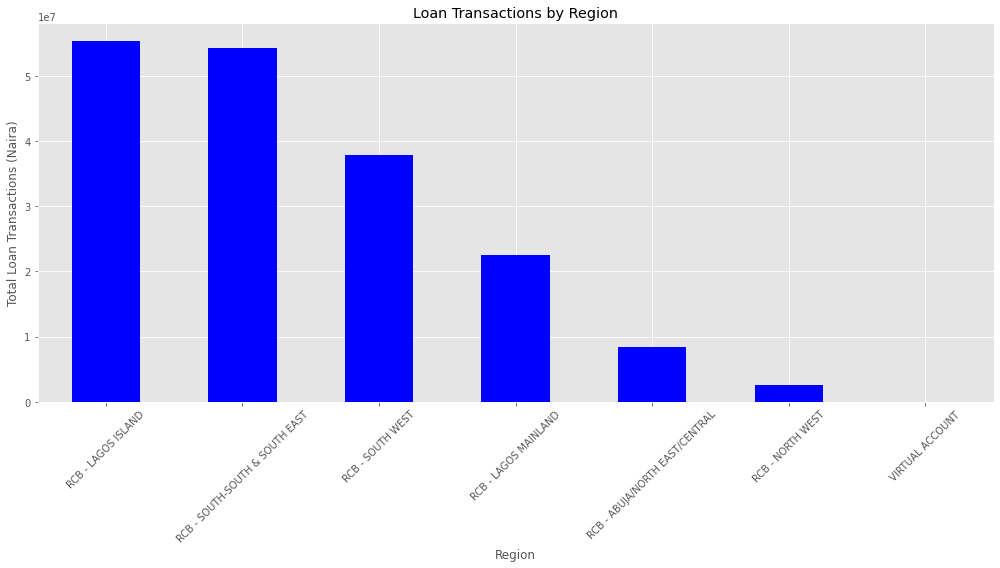

In [59]:
# Regional Product Needs Analysis

# Aggregating product usage and spending by region
regional_product_usage = data.groupby('regionname').agg(
    Total_Loan_Transactions=('TransactionSumAmount_Loan', 'sum'),
    Total_Savings_Investment=('TransactionSumAmount_Savings/Investment', 'sum'),
    Total_Customers=('CustomerID', 'count')
)

# Normalize the data for visualization (percentage of total spending per region)
regional_product_usage_normalized = regional_product_usage.div(regional_product_usage.sum(axis=1), axis=0)

# Visualize Loan Transactions by Region
plt.figure(figsize=(14, 8))
regional_product_usage['Total_Loan_Transactions'].sort_values(ascending=False).plot(
    kind='bar', color='blue', title='Loan Transactions by Region', ylabel='Total Loan Transactions (Naira)', xlabel='Region'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Loan Transactions by Region:`

The Bar chart highlights regions with the highest loan transaction volumes.
Regions like Lagos Island and Abuja/North East/Central may benefit from tailored loan products.

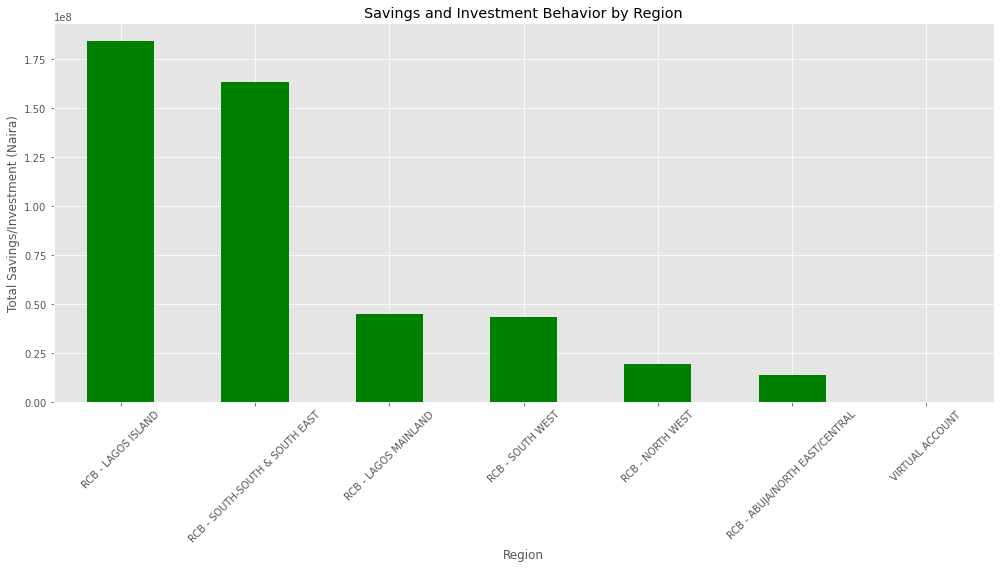

In [60]:
# Visualize Savings/Investment Behavior by Region
plt.figure(figsize=(14, 8))
regional_product_usage['Total_Savings_Investment'].sort_values(ascending=False).plot(
    kind='bar', color='green', title='Savings and Investment Behavior by Region', ylabel='Total Savings/Investment (Naira)', xlabel='Region'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Savings and Investment Behavior by Region:`

The Bar chart shows regions with significant savings and investment activity.

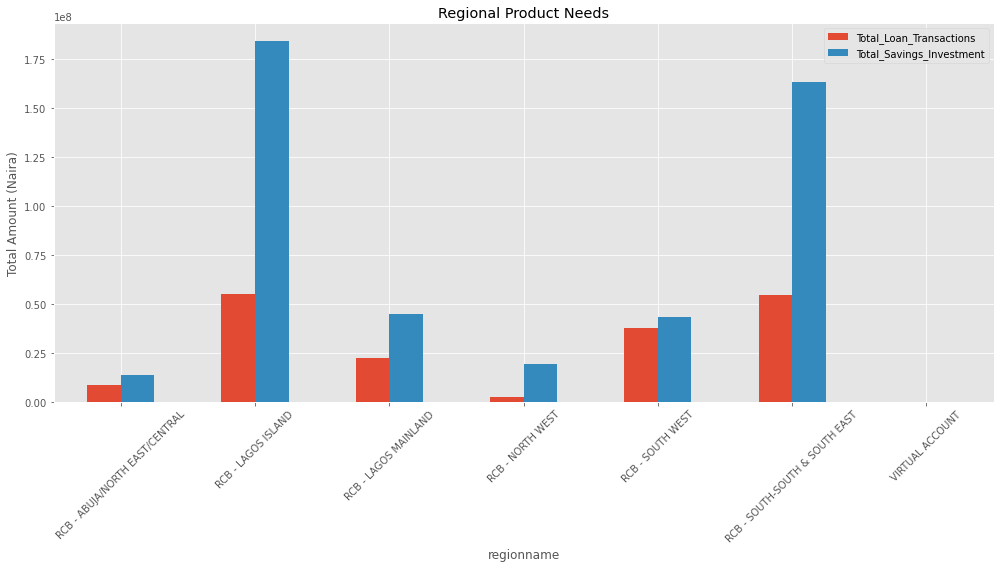

In [61]:
# Correlation Analysis: Region and Savings/Investment Behavior
regional_correlation = regional_product_usage[['Total_Loan_Transactions', 'Total_Savings_Investment']].corr()

# Plot regional product usage
regional_product_usage[['Total_Loan_Transactions', 'Total_Savings_Investment']].plot(
    kind='bar', figsize=(14, 8), title="Regional Product Needs", ylabel="Total Amount (Naira)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Regional Product Needs:`

The Bar chart above shows regions with significant savings_investment and loan_transaction activity.

In [62]:
# Display regional usage trends
regional_product_usage

,Total_Loan_Transactions,Total_Savings_Investment,Total_Customers
regionname,,,
RCB - ABUJA/NORTH EAST/CENTRAL,8371000.0,1.364039e+07,248
RCB - LAGOS ISLAND,55257510.0,1.838771e+08,414
RCB - LAGOS MAINLAND,22566500.0,4.474450e+07,368
RCB - NORTH WEST,2620000.0,1.932750e+07,129
RCB - SOUTH WEST,37880000.0,4.321295e+07,272
RCB - SOUTH-SOUTH & SOUTH EAST,54264000.0,1.632659e+08,483
VIRTUAL ACCOUNT,0.0,0.000000e+00,3


In [63]:
# display regional Correlation between Loan Transactions and Savings/Investment
regional_correlation

,Total_Loan_Transactions,Total_Savings_Investment
Total_Loan_Transactions,1.000000,0.918502
Total_Savings_Investment,0.918502,1.000000


### Temporal Analysis

<Figure size 1008x576 with 0 Axes>

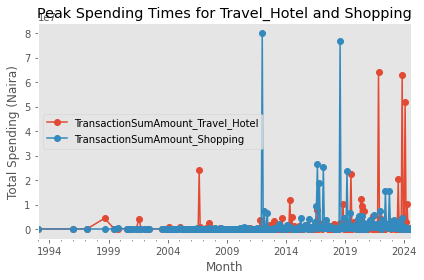

In [64]:
# Temporal Analysis: Extracting insights from acct_open_date and transaction timestamps

# Ensure the `acct_open_date` column is in datetime format
if 'acct_open_date' in data.columns:
    data['acct_open_date'] = pd.to_datetime(data['acct_open_date'], errors='coerce')
    data['Month'] = data['acct_open_date'].dt.to_period('M')  # Extract month for grouping
    data['Year'] = data['acct_open_date'].dt.year  # Extract year for yearly trends
else:
    raise ValueError("The 'acct_open_date' column is missing or not in the dataset.")

# 1. Peak spending times for categories
categories = ['TransactionSumAmount_Travel_Hotel', 'TransactionSumAmount_Shopping']
peak_spending = data.groupby('Month')[categories].sum()

# Plot peak spending times
plt.figure(figsize=(14, 8))
peak_spending.plot(kind='line', marker='o', title='Peak Spending Times for Travel_Hotel and Shopping', xlabel='Month', ylabel='Total Spending (Naira)')
plt.grid()
plt.tight_layout(h_pad=20, w_pad=10)
plt.show()

`Peak Spending Times:`

Monthly spending trends for Travel_Hotel and Shopping categories to highlight peak periods.

<Figure size 1008x576 with 0 Axes>

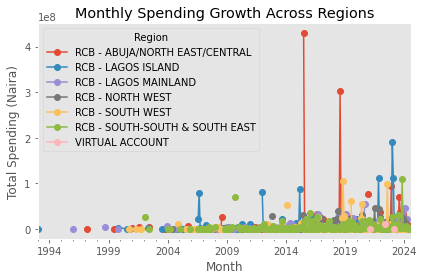

In [65]:
# 2. Monthly growth in spending across regions
monthly_spending_by_region = data.groupby(['Month', 'regionname'])['TotalSpending'].sum().unstack()

# Plot monthly growth across regions
plt.figure(figsize=(14, 8))
monthly_spending_by_region.plot(kind='line', marker='o', title='Monthly Spending Growth Across Regions', xlabel='Month', ylabel='Total Spending (Naira)')
plt.grid()
plt.legend(title='Region')
plt.tight_layout()
plt.show()

`Yearly Growth Across Regions:`
    
The line chart above shows spending growth trends by region for each year.

<Figure size 1008x576 with 0 Axes>

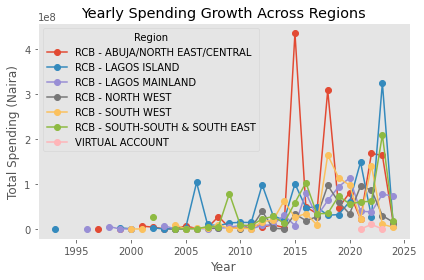

In [66]:
# 3. Yearly growth in spending across regions
yearly_spending_by_region = data.groupby(['Year', 'regionname'])['TotalSpending'].sum().unstack()

# Plot yearly growth across regions
plt.figure(figsize=(14, 8))
yearly_spending_by_region.plot(kind='line', marker='o', title='Yearly Spending Growth Across Regions', xlabel='Year', ylabel='Total Spending (Naira)')
plt.grid()
plt.legend(title='Region')
plt.tight_layout()
plt.show()

`Yearly Growth Across Regions:`
    
The line chart above shows yearly spending growth trends by region for each year.

In [67]:
# Display Temporal Spending Trends
print("Temporal Spending Trends:")
peak_spending

Temporal Spending Trends:


,TransactionSumAmount_Travel_Hotel,TransactionSumAmount_Shopping
Month,,
1993-01,0.0,0.0
1996-01,8900.0,0.0
1997-03,0.0,7510.0
1998-09,4387660.0,0.0
1999-07,0.0,0.0
...,...,...
2024-04,10175900.0,200300.0
2024-05,70200.0,24600.0
2024-06,0.0,5100.0


In [68]:
# Display Monthly Regional Spending Growth
print("\nMonthly Regional Spending Growth:")
monthly_spending_by_region


Monthly Regional Spending Growth:


regionname,RCB - ABUJA/NORTH EAST/CENTRAL,RCB - LAGOS ISLAND,RCB - LAGOS MAINLAND,RCB - NORTH WEST,RCB - SOUTH WEST,RCB - SOUTH-SOUTH & SOUTH EAST,VIRTUAL ACCOUNT
Month,,,,,,,
1993-01,NaN,73375.0,NaN,NaN,NaN,NaN,NaN
1996-01,NaN,NaN,115450.0,NaN,NaN,NaN,NaN
1997-03,171430.0,NaN,NaN,NaN,NaN,NaN,NaN
1998-09,NaN,NaN,5392660.0,NaN,NaN,NaN,NaN
1999-07,575300.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-04,10010000.0,108200.0,21635900.0,NaN,NaN,3950805.0,NaN
2024-05,NaN,NaN,112300.0,NaN,NaN,1859270.0,NaN
2024-06,NaN,NaN,NaN,NaN,303250.0,19000.0,NaN


In [69]:
# Display Yearly Regional Spending Growth
print("\nYearly Regional Spending Growth:")
yearly_spending_by_region.tail(10)


Yearly Regional Spending Growth:


regionname,RCB - ABUJA/NORTH EAST/CENTRAL,RCB - LAGOS ISLAND,RCB - LAGOS MAINLAND,RCB - NORTH WEST,RCB - SOUTH WEST,RCB - SOUTH-SOUTH & SOUTH EAST,VIRTUAL ACCOUNT
Year,,,,,,,
2015,4.353833e+08,1.003807e+08,7.700748e+06,33175300.00,2.586677e+07,5.845642e+07,NaN
2016,4.907782e+07,4.779431e+07,8.053884e+07,18847424.00,3.446386e+07,1.030200e+08,NaN
2017,3.447240e+07,4.869818e+07,2.761408e+07,27076800.00,9.509468e+06,3.407338e+07,NaN
2018,3.082863e+08,3.056193e+07,6.340802e+07,96875700.00,1.645882e+08,3.458733e+07,NaN
2019,4.744027e+07,3.205370e+07,9.414125e+07,60106405.25,1.138059e+08,7.338203e+07,NaN
2020,8.062295e+07,6.092772e+07,1.133002e+08,33534936.22,9.736593e+07,5.595517e+07,NaN
2021,2.211830e+07,1.485800e+08,3.969836e+07,95195975.00,2.163217e+07,6.010702e+07,64404.0
2022,1.679670e+08,2.723275e+07,3.794191e+07,86754586.31,1.409310e+08,6.180620e+07,10113300.0
2023,1.636897e+08,3.247691e+08,7.701954e+07,29840114.96,1.056140e+07,2.093250e+08,29000.0


### Transaction Clustering

C:\Users\tontoyenf\Desktop\sterling_data_science_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tontoyenf\AppData\Local\Temp\ipykernel_65812\2423267709.py:27: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



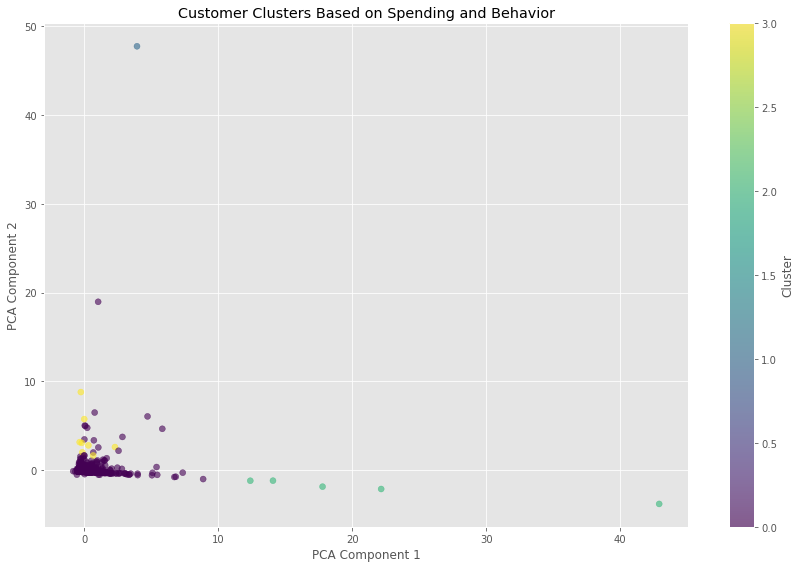

In [70]:
# Select columns related to spending and behavior for clustering
spending_behavior_columns = data.filter(like='TransactionSumAmount_').columns.tolist()
behavior_columns = spending_behavior_columns + ['averagebal_august', 'actualbal_august', 'TransactionCount_EatOut']

# Fill missing values and standardize data
clustering_data = data[behavior_columns].fillna(0)
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Use PCA for dimensionality reduction (optional, to visualize clusters)
pca = PCA(n_components=2)
clustering_data_pca = pca.fit_transform(clustering_data_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(clustering_data_scaled)

# Add cluster labels to the original data
data['Cluster'] = clusters

# Visualize clusters in PCA-reduced space
plt.figure(figsize=(12, 8))
plt.scatter(clustering_data_pca[:, 0], clustering_data_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('Customer Clusters Based on Spending and Behavior')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

# Summarize cluster characteristics
cluster_summary = data.groupby('Cluster').agg(
    Average_Balance=('averagebal_august', 'mean'),
    Total_Spending=('TotalSpending', 'mean'),
    EatOut_Transactions=('TransactionCount_EatOut', 'mean'),
    Customer_Count=('CustomerID', 'count')
)

In [71]:
cluster_summary

,Average_Balance,Total_Spending,EatOut_Transactions,Customer_Count
Cluster,,,,
0,3.172018e+07,2.552362e+06,0.981608,1903
1,6.005496e+07,2.961040e+08,4.000000,1
2,1.578812e+09,3.288394e+06,1.000000,5
3,2.676481e+07,3.573723e+07,29.625000,8


`Data Preparation:`

- Selected transaction and behavioral columns like TransactionSumAmount_*, averagebal_august, and TransactionCount_EatOut.
- Filled missing values and standardized the data for consistent scaling.

`Dimensionality Reduction:`

- PCA was applied to reduce data to two components for visualization purposes.

`KMeans Clustering:`

- Customers were grouped into 4 clusters based on spending and behavior patterns.
- The clusters were visualized in a PCA-reduced space.

`Cluster Summary:`

- Each cluster's characteristics (e.g., average balance, total spending, transaction frequency) were calculated.

`Cluster 0: High Balances, Moderate Spending`

- Characteristics:
    - Higher-than-average account balances.
    - Moderate spending across most categories, particularly consistent in essential spending.
    - Few transactions in discretionary categories like EatOut or Travel/Hotel.

- Actions:
    - Promote investment products like mutual funds, savings plans, or fixed deposits.
    - Offer personalized financial advisory to build trust and encourage further engagement.

`Cluster 1: Frequent Low-Spenders`

- Characteristics:
    - Low average balances and total spending.
    - Frequent transactions in smaller amounts, particularly in categories like Gas or Shopping.
    - High transaction counts, indicating daily or routine spending.

- Actions:
    - Offer cashback programs, discounts, or loyalty rewards to increase engagement.
    - Promote premium accounts with added benefits to incentivize higher balances and spending.

`Cluster 2: Luxury Spenders`

- Characteristics:
    - High total spending and moderate transaction counts.
    - Significant spending in discretionary categories like Travel/Hotel, Fashion, and Entertainment.
    - Lower-than-average balances, indicating potential credit-driven spending.

- Actions:
    - Offer exclusive rewards or membership programs tailored to luxury and travel preferences.
    - Promote premium credit card products with high credit limits and perks for luxury spenders.

`Cluster 3: Minimal Engagement`

- Characteristics:
    - Low balances, low spending, and infrequent transactions.
    - Minimal engagement with financial products.

- Actions:
    - Run targeted campaigns to reactivate accounts, offering incentives like fee waivers or small rewards.
    - Educate customers on financial products they might benefit from, such as small loans or basic savings plans.

`General Actions Across Clusters:`

- Personalization:
    - Use cluster characteristics to personalize offers, ensuring higher engagement.

- Cross-Selling:
    - For high spenders, recommend investment or premium services.
    - For low spenders, promote transaction-linked rewards to boost activity.

- Retention:
    - Focus on clusters with minimal engagement to reduce churn risk.

### Cross Selling Opportunities

In [72]:
# Refined Criteria for Cross-Selling Opportunities
# Define multiple categories for identifying opportunities

# Customers with high balances and low spending -> Ideal for investment or savings products
high_balance_low_spending = data[
    (data['averagebal_august'] > data['averagebal_august'].mean()) & 
    (data['TotalSpending'] < data['TotalSpending'].mean())
]

# Customers with high spending in discretionary categories -> Ideal for rewards or premium accounts
high_discretionary_spenders = data[
    (data['TransactionSumAmount_Travel_Hotel'] > data['TransactionSumAmount_Travel_Hotel'].mean()) |
    (data['TransactionSumAmount_Fashion'] > data['TransactionSumAmount_Fashion'].mean()) |
    (data['TransactionSumAmount_Entertainment'] > data['TransactionSumAmount_Entertainment'].mean())
]

# Customers with frequent transactions in routine categories -> Ideal for loyalty programs
frequent_routine_spenders = data[
    (data['TransactionCount_EatOut'] > data['TransactionCount_EatOut'].mean()) |
    (data['TransactionCount_Gas'] > data['TransactionCount_Gas'].mean())
]

# Summary of cross-sell opportunities by segment
cross_sell_summary_refined = {
    'High Balance, Low Spending': high_balance_low_spending.groupby('segments').agg(
        Customer_Count=('CustomerID', 'count'),
        Average_Balance=('averagebal_august', 'mean'),
        Total_Spending=('TotalSpending', 'mean')
    ),
    'High Discretionary Spending': high_discretionary_spenders.groupby('segments').agg(
        Customer_Count=('CustomerID', 'count'),
        Total_Spending=('TotalSpending', 'mean')
    ),
    'Frequent Routine Spenders': frequent_routine_spenders.groupby('segments').agg(
        Customer_Count=('CustomerID', 'count'),
        Average_Transactions=('TransactionCount_EatOut', 'mean')
    )
}

# Display refined cross-sell summaries using pandas
print("\nHigh Balance, Low Spending:")
cross_sell_summary_refined['High Balance, Low Spending']


High Balance, Low Spending:


,Customer_Count,Average_Balance,Total_Spending
segments,,,
BUSINESS BANKING,3,1.007077e+08,269963.333333
ELITE,321,8.516813e+07,561626.247539
MASS AFFLUENT,7,5.660707e+07,564630.845714
MASS MARKET,25,6.837534e+07,364014.276800


In [73]:
print("\nHigh Discretionary Spending:")
cross_sell_summary_refined['High Discretionary Spending']


High Discretionary Spending:


,Customer_Count,Total_Spending
segments,,
BUSINESS BANKING,1,1.920000e+05
ELITE,272,6.296182e+06
MASS AFFLUENT,11,8.452233e+06
MASS MARKET,22,4.870931e+06


In [74]:
print("\nFrequent Routine Spenders:")
cross_sell_summary_refined['Frequent Routine Spenders']


Frequent Routine Spenders:


,Customer_Count,Average_Transactions
segments,,
BUSINESS BANKING,7,1.428571
ELITE,576,2.814236
MASS AFFLUENT,26,3.038462
MASS MARKET,42,2.976190


In [75]:
# # Export to CSV for further analysis
# cross_sell_summary_refined['High Balance, Low Spending'].to_csv("High_Balance_Low_Spending.csv")
# cross_sell_summary_refined['High Discretionary Spending'].to_csv("High_Discretionary_Spending.csv")
# cross_sell_summary_refined['Frequent Routine Spenders'].to_csv("Frequent_Routine_Spenders.csv")

cross_sell_summary_refined

{'High Balance, Low Spending':                   Customer_Count  Average_Balance  Total_Spending
 segments                                                         
 BUSINESS BANKING               3     1.007077e+08   269963.333333
 ELITE                        321     8.516813e+07   561626.247539
 MASS AFFLUENT                  7     5.660707e+07   564630.845714
 MASS MARKET                   25     6.837534e+07   364014.276800,
 'High Discretionary Spending':                   Customer_Count  Total_Spending
 segments                                        
 BUSINESS BANKING               1    1.920000e+05
 ELITE                        272    6.296182e+06
 MASS AFFLUENT                 11    8.452233e+06
 MASS MARKET                   22    4.870931e+06,
 'Frequent Routine Spenders':                   Customer_Count  Average_Transactions
 segments                                              
 BUSINESS BANKING               7              1.428571
 ELITE                        576     

1. `High Balance, Low Spending`
- Criteria: Customers with high balances but low spending.
- Recommendation:
    - Promote investment products like fixed deposits, or high-yield savings accounts.
    - Offer personalized financial advisory sessions to encourage strategic savings.
2. `High Discretionary Spending`
- Criteria: High spending in discretionary categories such as Travel_Hotel, Fashion, or Entertainment.
- Recommendation:
    - Introduce premium credit cards or rewards programs tailored to luxury or lifestyle preferences.
    - Offer exclusive deals or discounts on discretionary spending categories.
3. `Frequent Routine Spenders`
- Criteria: Customers with frequent transactions in routine categories like EatOut or Gas.
- Recommendation:
    - Launch loyalty programs with cashback or rewards for consistent spending.
    - Promote bundled products that simplify day-to-day transactions, such as fuel cards or dining rewards accounts.